Notebook for analyzing the outputs of the GROMACS simulations for the mt-tRNAs. 

Works with .pdb and .xtc files.

Barnaba and function references to Bottaro et al., 2019. 

By: Mihir Gowda

## Dependencies

(Just run this section)

In [141]:
pip install barnaba -q

Note: you may need to restart the kernel to use updated packages.


In [142]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import mdtraj
import barnaba as bb
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import seaborn as sns
import scipy.stats as stats

In [143]:
mpl.style.use('seaborn-talk')

/tmp/ipykernel_1051/3104304036.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-talk')


## Functions

(Feel free to just run this section)

In [152]:
# Margin of Area to Detect Bonds

sqsides = .4

In [153]:
# Sugar Intreractions Coordinates

angle = -26
distance = .8
theta = np.radians(angle)
x = distance * np.cos(theta)
y = distance * np.sin(theta)
x1s = x - sqsides/2
x2s = x + sqsides/2
y1s = y - sqsides/2
y2s = y + sqsides/2

print("The Box Coorindates for Identifying Sugar Bonds:")
print(x1s, x2s, y1s, y2s)

The Box Coorindates for Identifying Sugar Bonds:
0.5190352370393336 0.9190352370393338 -0.5506969174312619 -0.15069691743126196


In [154]:
# Hoogsteen Interactions Coordinates

angle = 155
distance = .8
theta = np.radians(angle)
sqsides = .4
x = distance * np.cos(theta)
y = distance * np.sin(theta)
x1h = x - sqsides/2
x2h = x + sqsides/2
y1h = y - sqsides/2
y2h = y + sqsides/2

print("The Box Coorindates for Identifying Hoogsteen Bonds:")
print(x1h, x2h, y1h, y2h)

The Box Coorindates for Identifying Hoogsteen Bonds:
-0.92504622962932 -0.5250462296293199 0.13809460939255963 0.5380946093925596


In [155]:
# WC Interactions Coordinates

angle = 60
distance = .6
theta = np.radians(angle)
xwc = distance * np.cos(theta)
ywc = distance * np.sin(theta)

x1wc = xwc - sqsides/2
x2wc = xwc + sqsides/2
y1wc = ywc - sqsides/2
y2wc = ywc + sqsides/2

print("The Box Coorindates for Identifying Watson-Crick Bonds:")
print(x1wc, x2wc, y1wc, y2wc)

The Box Coorindates for Identifying Watson-Crick Bonds:
0.10000000000000003 0.5 0.3196152422706631 0.7196152422706632


In [176]:
def basehit(grouparray, title, x1, x2, y1, y2):
    
    """
    # Given the coordinates in the xy-plane, finds all base hits
    # across a simulation course in that region.
    # Incurs only for |z| < .18, although adjustable.
    
    input
    -------
    grouparray:
    title: <string> name of molecule, used in title
    x1: lower x bound
    x2: upper x bound
    y1: lower y bound
    y2: upper y bound
    
    
    output
    -------
    (means, sterrs)
    
    means: the average number of bond hits across all frames
    sterrs: the std error in these bond hits
    """
    
    # Edit resolution to divide up frames - lowers computational
    # complexity at the cost of quality
    resolution = 1
    freqs = []
    
    # Number of nucleotides
    n = grouparray[0].shape[1]
    
    for g in grouparray:
        # find all zero-elements
        rvecslimit = g[::resolution]
        nonzero = np.where(np.sum(rvecslimit**2, axis=3)>0.01)
        rr = rvecslimit[nonzero]
        nonzero = np.array(nonzero)

        # |z| is smaller than 0.18 nm
        # Adjust here for z coordinate
        pairs = rr[np.where(np.abs(rr[:,2])<0.18)]

        # Masking areas outside of the box defined
        ultmask = (np.abs(rr[:,2])<0.18) & ((rr[:,1])>y1) & ((rr[:,1])<y2) & ((rr[:,0])>x1) & ((rr[:,0])<x2)
        interacind = np.where(ultmask)
        pairsult = rr[interacind]
        interacind = np.array(interacind)
        interacnucs = nonzero[:, interacind][1:]

        freq2, xedges2, yedges2 = np.histogram2d(interacnucs[0][0], interacnucs[1][0], bins=n)
        
        freqs.append(freq2)

    # Highlighting a base in the 2-D plots, typically the mutant base
    highlighted = 49
    
    freqs = np.array(freqs)

    # Create a figure and axis object
    fig, ax = plt.subplots()
    
    # 2D average
    freq2D = np.mean(freqs, axis=0)

    # Plot the array using imshow with the custom color map
    im = ax.imshow(freq2D, cmap='plasma')

    # Draw a rectangle around the highlighted row
    rect = mpl.patches.Rectangle((-.5, highlighted-.5), freq2D.shape[1], 1, fill=False, edgecolor='white', lw=2)
    rect2 = mpl.patches.Rectangle((highlighted-.5, -.5), 1, freq2D.shape[1], fill=False, edgecolor='white', lw=2)
    ax.add_patch(rect)
    ax.add_patch(rect2)

    ax.set_xlabel("Nucleobase")

    cbar = fig.colorbar(im, ax=ax)

    ax.set_title(f"{title} Bonds")
    ax.set_yticks(np.arange(n-1, step = 10), np.arange(1, n+1, step=10))
    ax.set_xticks(np.arange(n-1, step = 10), np.arange(1, n+1, step=10))

    plt.show()
    
    means = np.mean(np.sum(freqs, axis=1), axis=0)
    sterrs = np.std(np.sum(freqs, axis=1), axis=0) / np.sqrt(3)
    plt.errorbar(np.arange(n), means, yerr=sterrs, fmt = 'o')
    plt.title(f"{title} Bond Hits", fontsize=18)
    plt.xticks(np.arange(n-1, step = 10), np.arange(1, n+1, step=10))
    plt.xlabel("Nucleobase")
    plt.grid(alpha=.5)
    plt.legend()
    
    plt.show()
    
    return means, sterrs

In [157]:
def base_interaction_fullpicture_box(title, rvecs):
    # find all zero-elements
    nonzero = np.where(np.sum(rvecs**2, axis=3)>0.01)
    rr = rvecs[nonzero]
    
    # define an helper function to plot the nucleobase and some distances, as a reference.
    def plot_grid():
        patches = []
        polygon = mpatches.RegularPolygon([0,0], 6, 0.28,fc='none',ec='k',lw=3,orientation=+np.pi/2)
        patches.append(polygon)
        polygon = mpatches.RegularPolygon([-0.375,-0.225], 5, 0.24,fc='none',ec='k',lw=3,orientation=-0.42)
        patches.append(polygon)
        circle = mpatches.Circle([0,0], 0.5, fc="none",ec='k',ls="--",lw=0.75)
        plt.text(-0.53,0,"r=0.5 nm",rotation=90,ha="center",va='center',fontsize=13)
        patches.append(circle)
        circle = mpatches.Circle([0,0], 0.75, fc="none",ec='k',ls="--",lw=0.75)
        plt.text(-0.78,0,"r=0.75 nm ",rotation=90,ha="center",va='center',fontsize=13)
        patches.append(circle)
        circle = mpatches.Circle([0,0], 1.0, fc="none",ec='k',ls="--",lw=0.75)
        plt.text(-1.03,0,"r=1.0 nm ",rotation=90,ha="center",va='center',fontsize=13)
        
        # Defining region for Sugar Bonds
        angle = -26
        distance = .8
        theta = np.radians(angle)
        xsugar = distance * np.cos(theta)
        ysugar = distance * np.sin(theta)
        
        # Defining region for Hoogsteen Bonds
        angle = 155
        distance = .8
        theta = np.radians(angle)
        xhoog = distance * np.cos(theta)
        yhoog = distance * np.sin(theta)
        
        # Defining region for WC Bonds
        angle = 60
        distance = .6
        theta = np.radians(angle)
        xwc = distance * np.cos(theta)
        ywc = distance * np.sin(theta)

        # Square region for Sugar Bonds
        square = mpatches.Rectangle((xsugar-.2, ysugar-.2), .4, .4, fill=False, color="purple", lw=.9)
        
        # Square region for Hoogsteen Bonds
        square2 = mpatches.Rectangle((xhoog-.2, yhoog-.2), .4, .4, fill=False, color="green", lw=.9)
        
        # Square region for WC Bonds
        square3 = mpatches.Rectangle((xwc-.2, ywc-.2), .4, .4, fill=False, color="black", lw=.9)
        
        patches.append(circle)
        patches.append(square)
        patches.append(square2)
        patches.append(square3)
        collection = PatchCollection(patches,match_original=True)
        ax.add_collection(collection)

        plt.plot([0,1.],[0,0],c='gray',lw=1,ls="--")
        plt.text(1.1,0,r"$\theta=0^\circ$",ha="center",va='center',fontsize=13)
        plt.plot([0,-np.cos(np.pi/3)],[0,np.sin(np.pi/3)],c='gray',lw=1,ls="--")
        plt.text(-np.cos(np.pi/3)*1.1,np.sin(np.pi/3)*1.1,r"$\theta=120^\circ$",ha="center",va='center',fontsize=13)

        plt.plot([0,-np.cos(np.pi/3)],[0,-np.sin(np.pi/3)],c='gray',lw=1,ls="--")
        plt.text(-np.cos(np.pi/3)*1.1,-np.sin(np.pi/3)*1.1,r"$\theta=240^\circ$",ha="center",va='center',fontsize=13)
        
        
        
        ax.set_aspect(1)
        ax.set_ylim(-1.1,1.1)
        ax.set_xlim(-1.1,1.1)
        ax.set_xlabel("x (nm)")
        ax.set_ylabel("y (nm)")

    # slice and take only where |z| is smaller than 0.18 nm
    pairs = rr[np.where(np.abs(rr[:,2])<0.18)]

    fig,ax = plt.subplots(figsize=(10,10))
    # do a KDE 
    ax = sns.kdeplot(x=pairs[:, 0], y=pairs[:, 1], fill=True, bw_method=.12)
    # scatter plot x and y
    ax.scatter(pairs[:,0],pairs[:,1],s=0.5,c='r')
    # make labels
    ax.text(0.35,0.45,"Watson-Crick",fontsize=17,ha='center',va='center',color='black')
    ax.text(0.1,0.6,"GU",fontsize=17,ha='center',va='center',color='k')
    ax.text(0.5,0.3,"GU",fontsize=17,ha='center',va='center',color='k')
    ax.text(-0.7,0.3,"Hoogsteen",fontsize=17,ha='center',va='center',color='green')
    ax.text(0.7,-0.3,"Sugar",fontsize=17,ha='center',va='center',color='purple')
    ax.set_title(title)
    
    plot_grid()
    plt.show()

In [164]:
def two_base_distances(title, b1, b2, rvecs, res):
    fig,ax = plt.subplots(figsize=(10,10))
    dist = np.sqrt(np.sum(rvecs[:,b1,b2]**2,axis=1))
    ax.scatter(np.arange(len(dist)),dist,s=1)
    ax.set_xlabel("Frame number")
    ax.set_ylabel("%s/%s distance (nm)" % (res[b1][:-2],res[b2][:-2]))
    ax.set_title(title)
    plt.show()

In [165]:
def two_base_distances_kdeplot(title, b1, b2, rvecs, res, color, a):
#     fig,ax = plt.subplots(figsize=(10,10))
    dist = np.sqrt(np.sum(rvecs[:,b1,b2]**2,axis=1))
#     ax.scatter(np.arange(len(dist)),dist,s=1)
#     ax.set_xlabel("Frame number")
#     ax.set_ylabel("%s/%s distance (nm)" % (res[b1][:-2],res[b2][:-2]))
    sns.kdeplot(np.sqrt(np.sum(rvecs[:,b1,b2]**2,axis=1)), color = color, alpha = a, fill=True)
#     plt.xlabel("%s to %s distance (nm)" % (res[b1][:-2],res[b2][:-2]))
    plt.xlabel(f"Base {b1+1} to Base {b2+1} distance (nm)")
    plt.title(title)
#     plt.show()

In [166]:
%cd mttrnas/

[Errno 2] No such file or directory: 'Newaim/leu/'
/mnt/c/Users/cyber/Documents/Gromacs/atomistic/Newaim


## Analyzing Met

In [19]:
%cd ../met/
!ls

/mnt/c/Users/cyber/Documents/Gromacs/atomistic/Newaim/met
met.28956.pdb		     met.28956.pdb.top	 sim_100   sim_80
met.28956.pdb.gro	     met.tar.gz		 sim_60    sim_90
met.28956.pdb.ndx	     met_60to100_VMD	 sim_70    sim_foldfrom130_60
met.28956.pdb.output	     met_nolastatom.pdb  sim_70_2  sim_melt
met.28956.pdb.settings.used  sim		 sim_70_3  sim_melt_130


In [20]:
!ls sim/

confout.gro  md.log	met_run.tpr  state_prev.cpt  traj.trr
ener.edr     mdout.mdp	state.cpt    tc_center.xtc   traj_comp.xtc


In [21]:
nativemet = "met.28956.pdb"
trajmet = "sim_70/tc_center.xtc"
trajmet2 = "sim_70_2/tc_center.xtc"
trajmet3 = "sim_70_3/tc_center.xtc"

trajmet60 = "sim_60/tc_center.xtc"
trajmet80 = "sim_80/tc_center.xtc"
trajmet90 = "sim_90/tc_center.xtc"
trajmet100 = "sim_100/tc_center.xtc"

topmet = "met.28956.pdb.gro"

In [62]:
ermsd60 = bb.ermsd(nativemet, trajmet60, topology=topmet)
ermsd70 = bb.ermsd(nativemet, trajmet, topology=topmet)
ermsd80 = bb.ermsd(nativemet, trajmet80, topology=topmet)
ermsd90 = bb.ermsd(nativemet, trajmet90, topology=topmet)
ermsd100 = bb.ermsd(nativemet, trajmet100, topology=topmet)

# Loaded reference met.28956.pdb 
# Loaded target sim_60/tc_center.xtc 
# Loaded reference met.28956.pdb 
# Loaded target sim_70/tc_center.xtc 
# Loaded reference met.28956.pdb 
# Loaded target sim_80/tc_center.xtc 
# Loaded reference met.28956.pdb 
# Loaded target sim_90/tc_center.xtc 
# Loaded reference met.28956.pdb 
# Loaded target sim_100/tc_center.xtc 


In [63]:
ermsdlist = [ermsd60, ermsd70, ermsd80, ermsd90, ermsd100]
templist = ['60', '70', '80', '90', '100']

Text(0.5, 1.0, '')

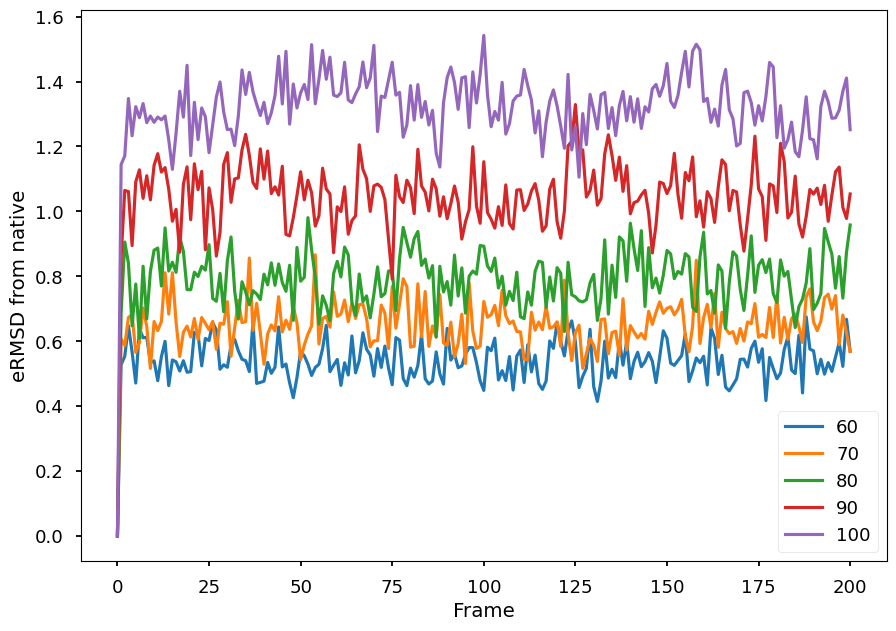

In [64]:
for i, e in enumerate(ermsdlist):
    plt.xlabel("Frame")
    plt.ylabel("eRMSD from native")
    plt.plot(e[::50], label = templist[i])

plt.legend()
plt.title("")

Text(0.5, 1.0, 'Variation in Structural Integrity of mt-tRNA_Met Upon Heating')

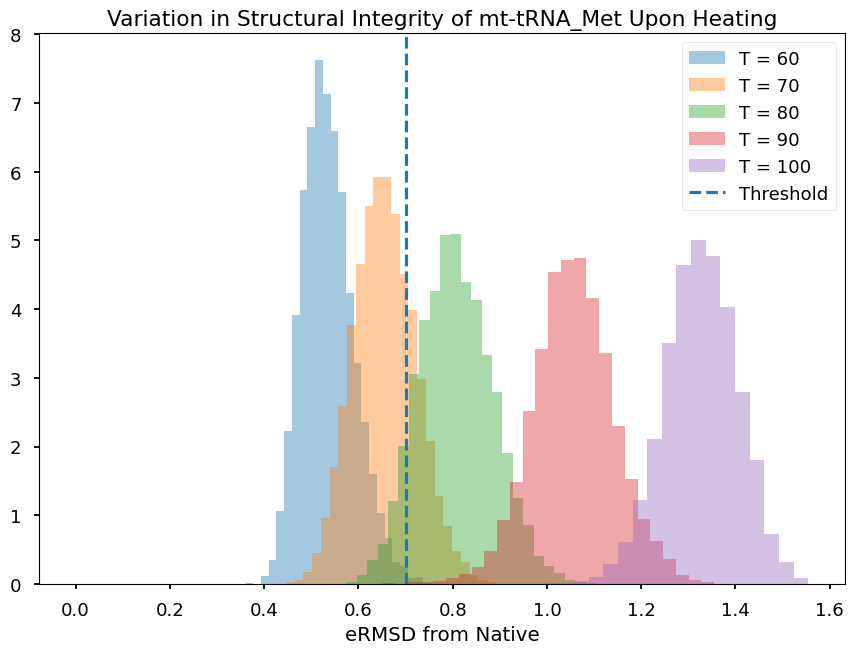

In [66]:
for i, e in enumerate(ermsdlist):
    plt.hist(e,density=True,bins=50, alpha = .4, label = f"T = {templist[i]}")
    
plt.axvline(.7, linestyle = '--', label = "Threshold")    
plt.legend()
plt.xlabel("eRMSD from Native")
plt.title("Variation in Structural Integrity of mt-tRNA_Met Upon Heating")

In [22]:
rvecsmet, res = bb.dump_rvec(trajmet, topology=topmet, cutoff=100)
rvecsmet2, res = bb.dump_rvec(trajmet2, topology=topmet, cutoff=100)
rvecsmet3, res = bb.dump_rvec(trajmet3, topology=topmet, cutoff=100)

# Loading sim_70/tc_center.xtc 


In [16]:
rvecsmetcutoff, resmet = bb.dump_rvec(trajmet, topology=topmet, cutoff=3.5)
rvecsmet2cutoff, resmet = bb.dump_rvec(trajmet2, topology=topmet, cutoff=3.5)
rvecsmet3cutoff, resmet = bb.dump_rvec(trajmet3, topology=topmet, cutoff=3.5)

# Loading sim_70/tc_center.xtc 
# Loading sim_70_2/tc_center.xtc 
# Loading sim_70_3/tc_center.xtc 


In [27]:
ermsdmet = bb.ermsd(nativemet, trajmet, topology=topmet)
rmsdmet = bb.rmsd(nativemet,trajmet,topology=topmet,heavy_atom=False)

# Loaded reference met.28956.pdb 
# Loaded target sim_70/tc_center.xtc 


# found  837 atoms in common


In [29]:
ermsdmet2 = bb.ermsd(nativemet, trajmet2, topology=topmet)
rmsdmet2 = bb.rmsd(nativemet,trajmet2,topology=topmet,heavy_atom=False)

ermsdmet3 = bb.ermsd(nativemet, trajmet3, topology=topmet)
rmsdmet3 = bb.rmsd(nativemet,trajmet3,topology=topmet,heavy_atom=False)

# Loaded reference met.28956.pdb 
# Loaded target sim_70_2/tc_center.xtc 


# found  837 atoms in common


# Loaded reference met.28956.pdb 
# Loaded target sim_70_3/tc_center.xtc 


# found  837 atoms in common


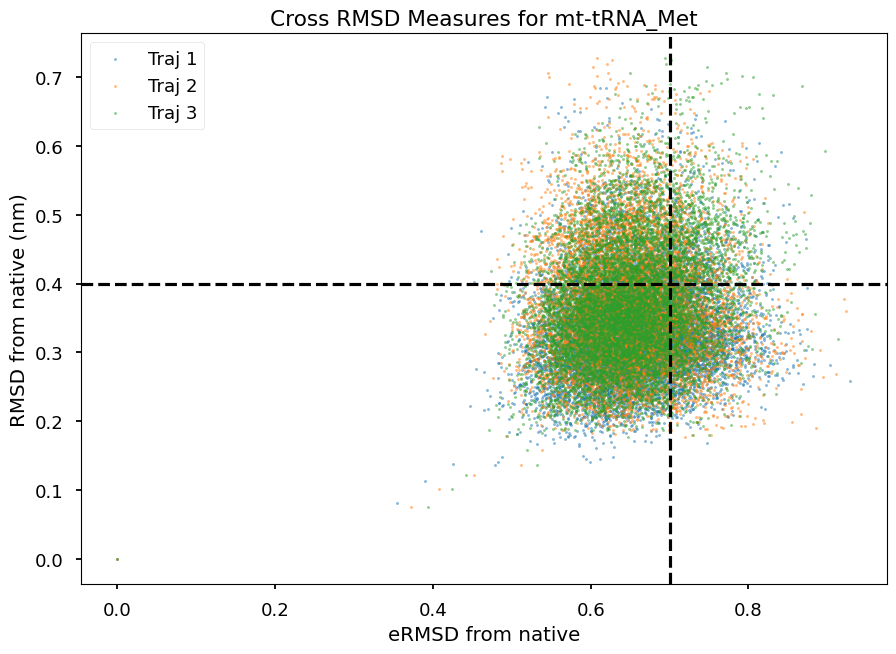

In [34]:
plt.xlabel("eRMSD from native")
plt.ylabel("RMSD from native (nm)")
plt.axhline(0.4,ls = "--", c= 'k')
plt.axvline(0.7,ls = "--", c= 'k')
plt.title("Cross RMSD Measures for mt-tRNA_Met")
a = .5
plt.scatter(ermsdmet,rmsdmet,s=2.5, label = "Traj 1", alpha = a)
plt.scatter(ermsdmet2,rmsdmet3,s=2.5, label = "Traj 2", alpha = a)
plt.scatter(ermsdmet3,rmsdmet3,s=2.5, label = "Traj 3", alpha = a)
plt.legend()
plt.show()

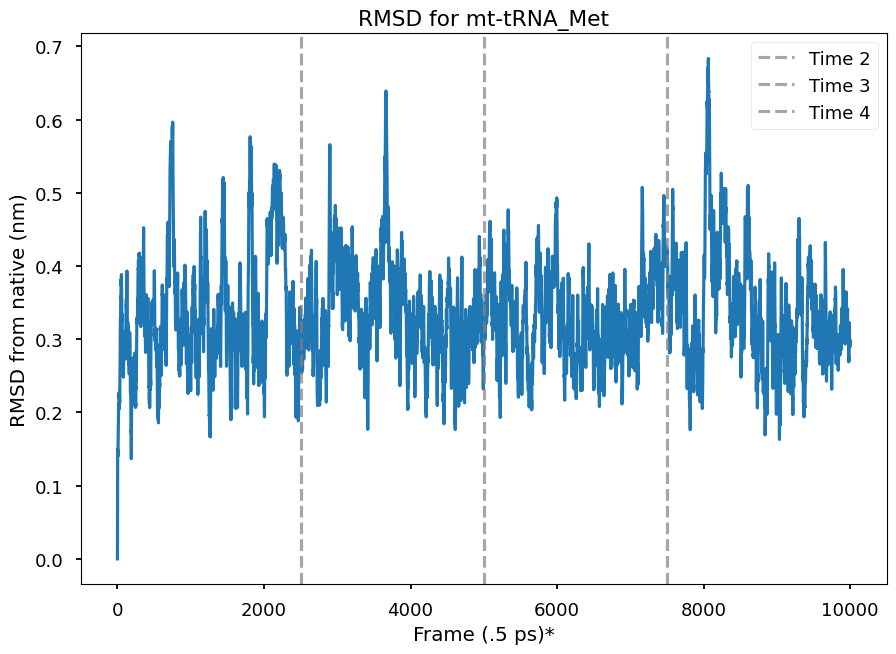

In [47]:
plt.plot(rmsdmet)
plt.title("RMSD for mt-tRNA_Met")
plt.xlabel("Frame (.5 ps)*")
plt.ylabel("RMSD from native (nm)")
plt.axvline(2500, linestyle='--', c='gray', alpha = .7, label = "Time 2")
plt.axvline(5000, linestyle='--', c='gray', alpha = .7, label = "Time 3")
plt.axvline(7500, linestyle='--', c='gray', alpha = .7, label = "Time 4")
# plt.axvline(2500, linestyle='--', c='gray', alpha = .7, label = "Time 1")
plt.legend()

In [24]:
# Met indices

# Acc stem
met_accstem = np.concatenate((np.linspace(0, 6, 7), np.linspace(60, 66, 7)))
# D stem
met_dstem = np.concatenate((np.linspace(9, 12, 4), np.linspace(18, 21, 4)))
# D loop
met_dloop = np.linspace(13, 17, 5)
# Ac stem
met_acstem = np.concatenate((np.linspace(23, 27, 5), np.linspace(35, 39, 5)))
# Anticodon loop
met_anticodonloop = np.linspace(28, 34, 7)
# T stem
met_tstem = np.concatenate((np.linspace(44, 48, 5), np.linspace(55, 59, 5)))
# T loop
met_tloop = np.linspace(49, 54, 6)

s_and_l = [met_accstem, met_dstem, met_dloop, met_acstem, met_anticodonloop, met_tstem, met_tloop]
loops = [met_dloop, met_anticodonloop, met_tloop]
stems = [met_accstem, met_dstem, met_acstem, met_tstem]
s_and_l_names = ['Acc Stem', 'D Stem', 'D Loop', 'Ac Stem', 'Anticodon Loop', 'T Stem', 'T Loop']
loopnames = ['D Loop', 'Anticodon Loop', 'T Loop']
stemnames = ['Acc Stem', 'D Stem', 'Ac Stem', 'T Stem']

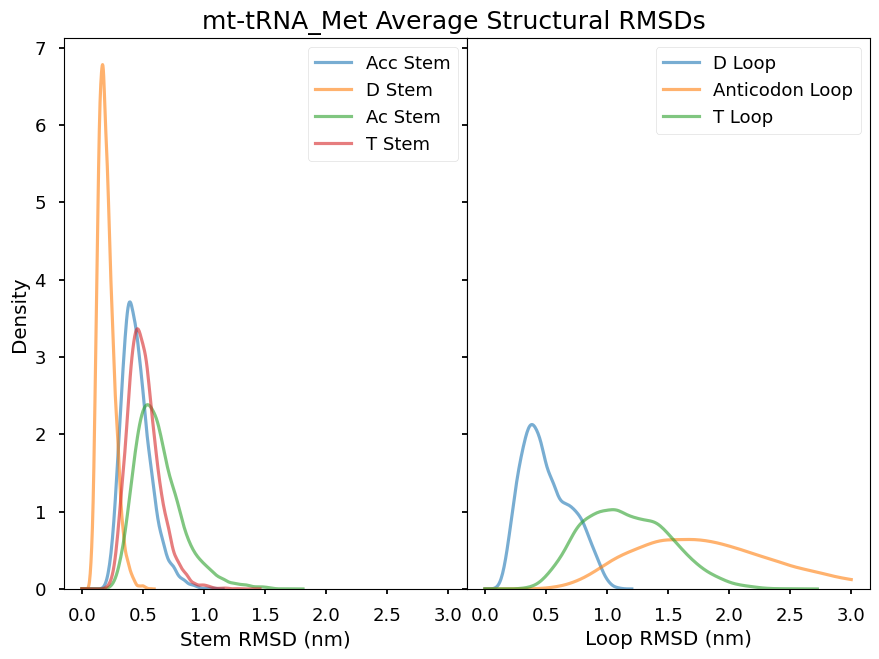

In [87]:
# fig,ax = plt.subplots(figsize=(10,10))

fig = plt.figure()
gs = fig.add_gridspec(1, 2, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)
fig.suptitle('mt-tRNA_Met Average Structural RMSDs', y=.92, fontsize=18)

for i, sl in enumerate(stems):
    dists = []
    for j in sl:
        j = int(j)
#         dists.append(np.sqrt(np.sum((np.mean((rvecsmet[:,j,:] - rvecsmet[0,j,:]), axis = 1))**2,axis=1)))
        dists.append(np.sqrt(np.sum((np.mean(rvecsmet[:,j,:] - rvecsmet[0,j,:], axis=1))**2,axis=1)))
    overall = np.mean(dists, axis = 0)
#     plt.hist(overall, alpha = .6, label = s_and_l_names[i], bins = 100, range = [0, 0.2])
    sns.kdeplot(overall, alpha = .6, label = stemnames[i], clip = (0, 3), ax=axs[0])
    
for i, sl in enumerate(loops):
    dists = []
    for j in sl:
        j = int(j)
#         dists.append(np.sqrt(np.sum((np.mean((rvecsmet[:,j,:] - rvecsmet[0,j,:]), axis = 1))**2,axis=1)))
        dists.append(np.sqrt(np.sum((np.mean(rvecsmet[:,j,:] - rvecsmet[0,j,:], axis=1))**2,axis=1)))
    overall = np.mean(dists, axis = 0)
#     plt.hist(overall, alpha = .6, label = s_and_l_names[i], bins = 100, range = [0, 0.2])
    sns.kdeplot(overall, alpha = .6, label = loopnames[i], clip = (0, 3), ax=axs[1])   
    
#     ax.scatter(np.arange(len(dist)),dist,s=1)
axs[0].set_xlabel("Stem RMSD (nm)")
axs[1].set_xlabel("Loop RMSD (nm)")
axs[0].legend()
axs[1].legend()
# ax.set_ylabel("%s/%s distance (nm)" % (resmet[b1][:-2],resmet[b2][:-2]))
plt.show()

In [25]:
number_nuc = rvecsmet[0,:,0].shape[0]
nuc_dists = []

for n in range(number_nuc):
    alldists = (np.sqrt(np.sum((np.mean(rvecsmet[:,n,:] - rvecsmet[0,n,:], axis=1))**2,axis=1)))
    nuc_dists.append(alldists)
    
nuc_dists = np.array(nuc_dists)

In [52]:
number_nuc = rvecsmet2[0,:,0].shape[0]
nuc_dists2 = []

for n in range(number_nuc):
    alldists = (np.sqrt(np.sum((np.mean(rvecsmet2[:,n,:] - rvecsmet2[0,n,:], axis=1))**2,axis=1)))
    nuc_dists2.append(alldists)
    
nuc_dists2 = np.array(nuc_dists2)

In [50]:
number_nuc = rvecsmet3[0,:,0].shape[0]
nuc_dists3 = []

for n in range(number_nuc):
    alldists = (np.sqrt(np.sum((np.mean(rvecsmet3[:,n,:] - rvecsmet3[0,n,:], axis=1))**2,axis=1)))
    nuc_dists3.append(alldists)
    
nuc_dists3 = np.array(nuc_dists3)

In [53]:
med_nucd = np.median(nuc_dists, axis = 1)
med_nucd2 = np.median(nuc_dists2, axis=1)
med_nucd3 = np.median(nuc_dists3, axis=1)

In [58]:
med_nuc_avg = np.mean((med_nucd, med_nucd2, med_nucd3), axis=0)
med_nuc_stds = np.std((med_nucd, med_nucd2, med_nucd3), axis=0) / np.sqrt(3)

In [81]:
largest_flucs = np.argsort(med_nuc_avg)[-10:][::-1]
s_flucs = np.argsort(med_nuc_avg)[:10][::]
print(med_nuc_avg[largest_flucs])
print(med_nuc_avg[s_flucs])
# print(s_flucs)

[3.69910058 2.34428184 2.22271496 1.77629399 1.73139621 1.64184936
 1.53493879 1.38198534 1.32566364 1.22293517]
[0.17890112 0.17929568 0.1795073  0.18077238 0.18820941 0.19408785
 0.19478686 0.19501697 0.19897292 0.21123423]
[ 7 18 42 12 19 10 17  8 11 13]


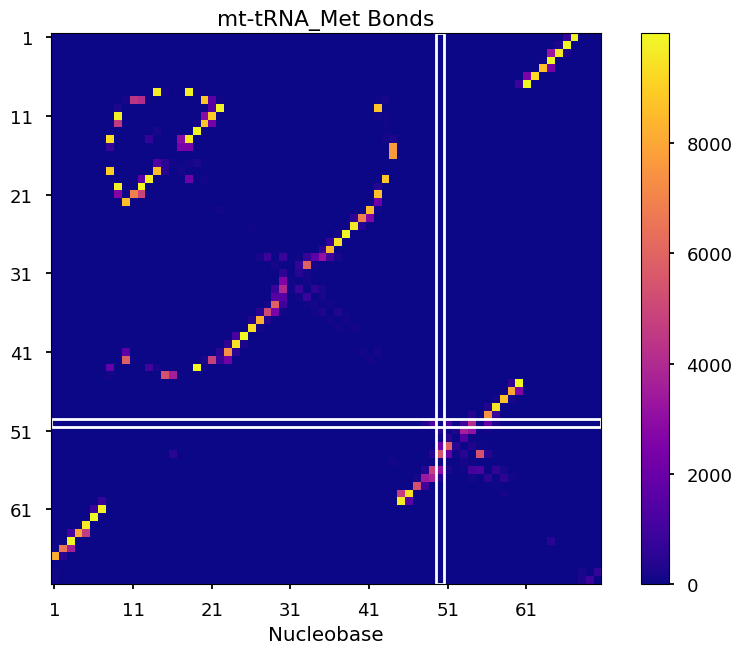

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


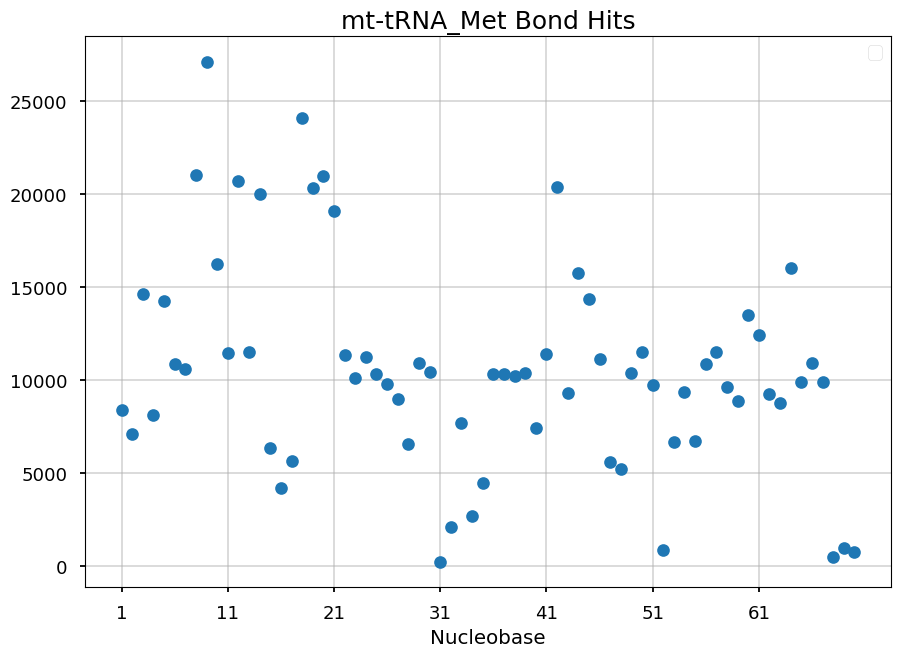

In [95]:
# Looking at entire area around nucleobases
metm, metstd = basehit((rvecsmet, rvecsmet2, rvecsmet3),
                      "mt-tRNA_Met", 
                      -.8, .8, -.8, .8)

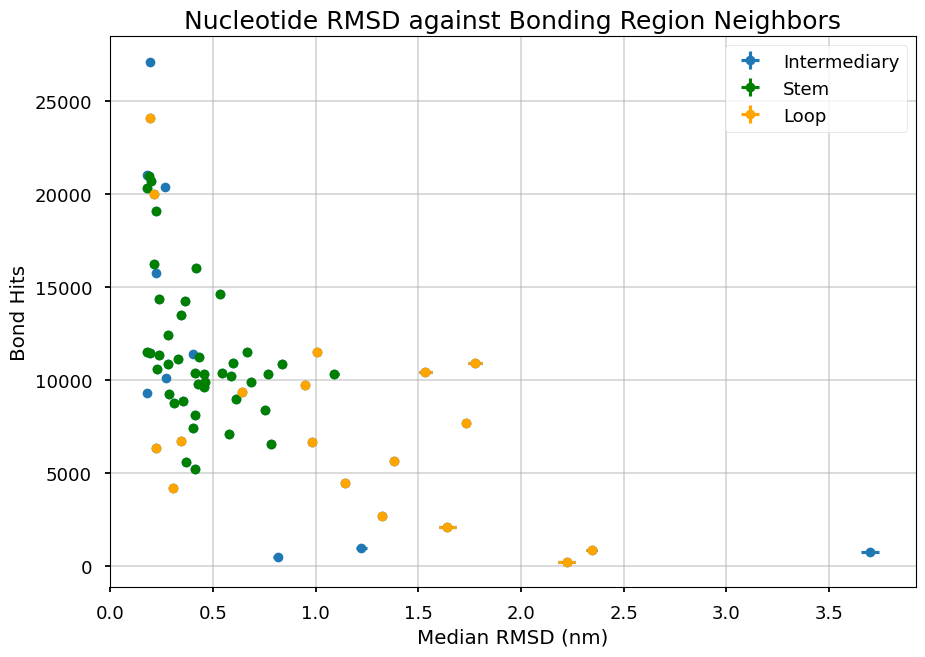

In [112]:
plt.errorbar(med_nuc_avg,
            metm,
            xerr = med_nuc_stds,
            yerr = metstd, 
            fmt = "o",
            markersize = 7,
            label = "Intermediary")

for i, sl in enumerate(stems):
    sl = sl.astype(int)
    plt.errorbar(med_nuc_avg[sl],
        metm[sl],
        xerr = med_nuc_stds[sl],
        yerr = metstd[sl], 
        fmt = "o",
        markersize = 7,
        label = "Stem",
        color = "green")
        
        
for i, sl in enumerate(loops):
    sl = sl.astype(int)
    plt.errorbar(med_nuc_avg[sl],
        metm[sl],
        xerr = med_nuc_stds[sl],
        yerr = metstd[sl], 
        fmt = "o",
        markersize = 7,
        label = "Loop",
        color = "orange")

plt.grid(alpha=.5)
plt.ylabel("Bond Hits")
plt.xlabel("Median RMSD (nm)")
plt.title("Nucleotide RMSD against Bonding Region Neighbors", fontsize = 18)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

## Val

In [113]:
%cd ../val/
!ls

/mnt/c/Users/cyber/Documents/Gromacs/atomistic/Newaim/val
sim	  val.28955.pdb		val.28955.pdb.settings.used
sim_70	  val.28955.pdb.gro	val.28955.pdb.top
sim_70_2  val.28955.pdb.ndx	val.tar.gz
sim_70_3  val.28955.pdb.output	val_nolastthree_adj.pdb


In [114]:
nativeval = "val.28955.pdb"
trajval = "sim_70/tc_center.xtc"
trajval2 = "sim_70_2/tc_center.xtc"
trajval3 = "sim_70_3/tc_center.xtc"
topval = "val.28955.pdb.gro"

In [115]:
rvecsval, resval = bb.dump_rvec(trajval, topology=topval, cutoff=100)
rvecsval2, resval = bb.dump_rvec(trajval2, topology=topval, cutoff=100)
rvecsval3, resval = bb.dump_rvec(trajval3, topology=topval, cutoff=100)

# Loading sim_70/tc_center.xtc 
# Loading sim_70_2/tc_center.xtc 
# Loading sim_70_3/tc_center.xtc 


In [30]:
rvecsvalc, resval = bb.dump_rvec(trajval, topology=topval, cutoff=3.5)
rvecsvalc2, resval = bb.dump_rvec(trajval2, topology=topval, cutoff=3.5)
rvecsvalc3, resval = bb.dump_rvec(trajval3, topology=topval, cutoff=3.5)

# Loading sim_70/tc_center.xtc 
# Loading sim_70_2/tc_center.xtc 
# Loading sim_70_3/tc_center.xtc 


In [19]:
ermsdval = bb.ermsd(nativeval, trajval, topology=topval)
rmsdval = bb.rmsd(nativeval,trajval,topology=topval,heavy_atom=False)
ermsdval2 = bb.ermsd(nativeval, trajval2, topology=topval)
rmsdval2 = bb.rmsd(nativeval,trajval2,topology=topval,heavy_atom=False)
ermsdval3 = bb.ermsd(nativeval, trajval3, topology=topval)
rmsdval3 = bb.rmsd(nativeval,trajval3,topology=topval,heavy_atom=False)

# Loaded reference val.28955.pdb 
# Loaded target sim_70/tc_center.xtc 


# found  828 atoms in common


# Loaded reference val.28955.pdb 
# Loaded target sim_70_2/tc_center.xtc 


# found  828 atoms in common


# Loaded reference val.28955.pdb 
# Loaded target sim_70_3/tc_center.xtc 


# found  828 atoms in common


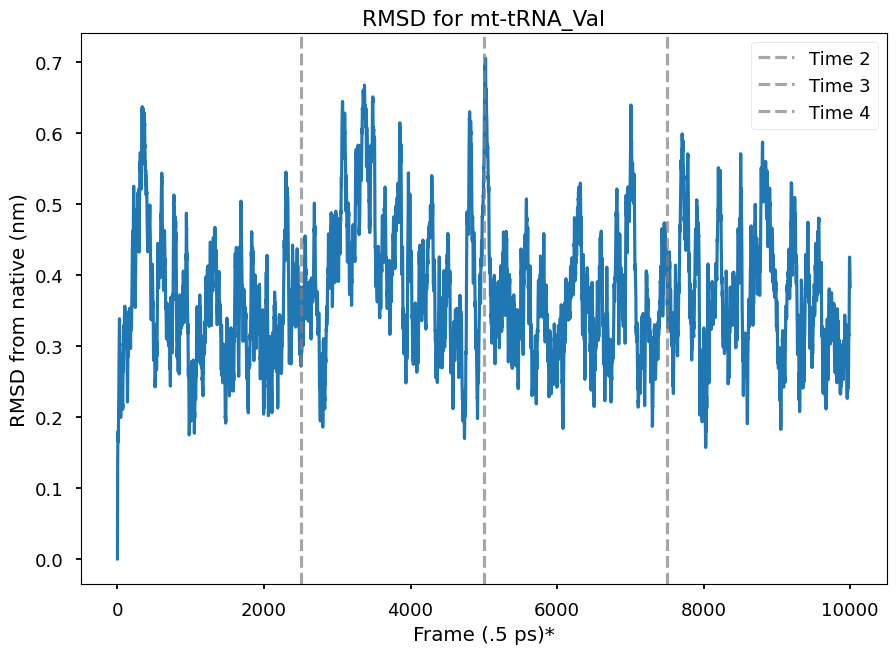

In [20]:
plt.plot(rmsdval)
plt.title("RMSD for mt-tRNA_Val")
plt.xlabel("Frame (.5 ps)*")
plt.ylabel("RMSD from native (nm)")
plt.axvline(2500, linestyle='--', c='gray', alpha = .7, label = "Time 2")
plt.axvline(5000, linestyle='--', c='gray', alpha = .7, label = "Time 3")
plt.axvline(7500, linestyle='--', c='gray', alpha = .7, label = "Time 4")
# plt.axvline(2500, linestyle='--', c='gray', alpha = .7, label = "Time 1")
plt.legend()

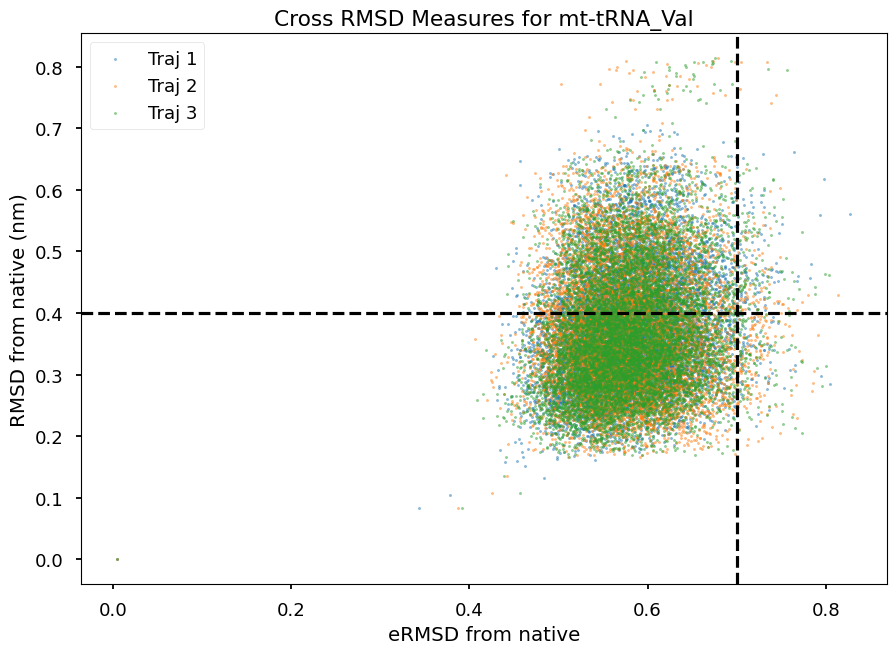

In [22]:
plt.xlabel("eRMSD from native")
plt.ylabel("RMSD from native (nm)")
plt.axhline(0.4,ls = "--", c= 'k')
plt.axvline(0.7,ls = "--", c= 'k')
plt.title("Cross RMSD Measures for mt-tRNA_Val")
a = .5
plt.scatter(ermsdval,rmsdval,s=2.5, label = "Traj 1", alpha = a)
plt.scatter(ermsdval2,rmsdval3,s=2.5, label = "Traj 2", alpha = a)
plt.scatter(ermsdval3,rmsdval3,s=2.5, label = "Traj 3", alpha = a)
plt.legend()
plt.show()

In [91]:
# Val indices

# Acc stem
val_accstem = np.concatenate((np.linspace(0, 6, 7), np.linspace(61, 67, 7)))
# D stem
val_dstem = np.concatenate((np.linspace(9, 12, 4), np.linspace(19, 22, 4)))
# D loop
val_dloop = np.linspace(13, 18, 6)
# Ac stem
val_acstem = np.concatenate((np.linspace(24, 28, 5), np.linspace(36, 40, 5)))
# Anticodon loop
val_anticodonloop = np.linspace(29, 35, 7)
# T stem
val_tstem = np.concatenate((np.linspace(45, 49, 5), np.linspace(56, 60, 5)))
# T loop
val_tloop = np.linspace(50, 55, 6)

vs_and_l = [val_accstem, val_dstem, val_dloop, val_acstem, val_anticodonloop, val_tstem, val_tloop]
vloops = [val_dloop, val_anticodonloop, val_tloop]
vstems = [val_accstem, val_dstem, val_acstem, val_tstem]
vs_and_l_names = ['Acc Stem', 'D Stem', 'D Loop', 'Ac Stem', 'Anticodon Loop', 'T Stem', 'T Loop']
loopnames = ['D Loop', 'Anticodon Loop', 'T Loop']
stemnames = ['Acc Stem', 'D Stem', 'Ac Stem', 'T Stem']

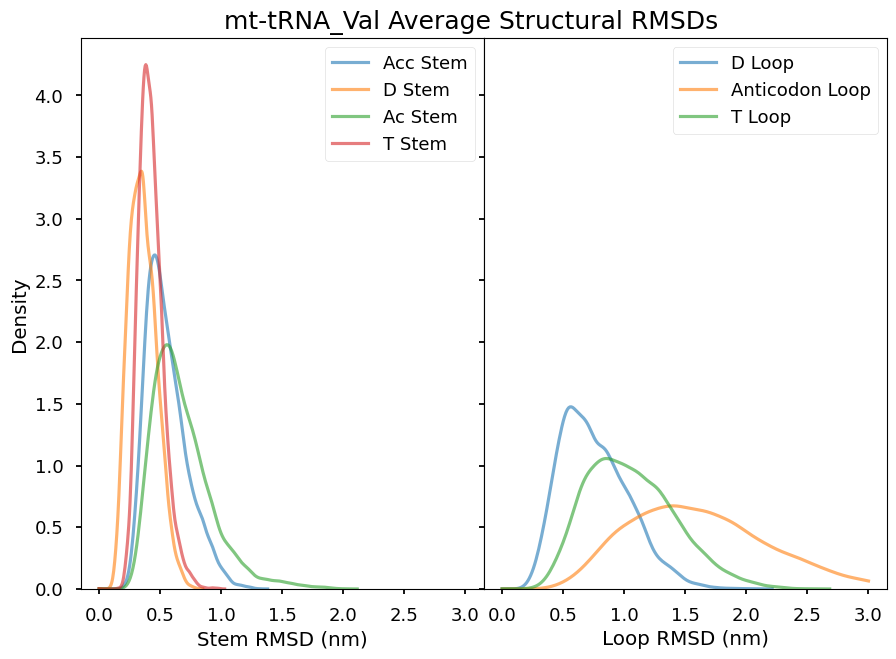

In [93]:
# fig,ax = plt.subplots(figsize=(10,10))

fig = plt.figure()
gs = fig.add_gridspec(1, 2, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)
fig.suptitle('mt-tRNA_Val Average Structural RMSDs', y=.92, fontsize=18)

for i, sl in enumerate(vstems):
    dists = []
    for j in sl:
        j = int(j)
#         dists.append(np.sqrt(np.sum((np.mean((rvecsmet[:,j,:] - rvecsmet[0,j,:]), axis = 1))**2,axis=1)))
        dists.append(np.sqrt(np.sum((np.mean(rvecsval[:,j,:] - rvecsval[0,j,:], axis=1))**2,axis=1)))
    overall = np.mean(dists, axis = 0)
#     plt.hist(overall, alpha = .6, label = s_and_l_names[i], bins = 100, range = [0, 0.2])
    sns.kdeplot(overall, alpha = .6, label = stemnames[i], clip = (0, 3), ax=axs[0])
    
for i, sl in enumerate(vloops):
    dists = []
    for j in sl:
        j = int(j)
#         dists.append(np.sqrt(np.sum((np.mean((rvecsmet[:,j,:] - rvecsmet[0,j,:]), axis = 1))**2,axis=1)))
        dists.append(np.sqrt(np.sum((np.mean(rvecsval[:,j,:] - rvecsval[0,j,:], axis=1))**2,axis=1)))
    overall = np.mean(dists, axis = 0)
#     plt.hist(overall, alpha = .6, label = s_and_l_names[i], bins = 100, range = [0, 0.2])
    sns.kdeplot(overall, alpha = .6, label = loopnames[i], clip = (0, 3), ax=axs[1])   
    
#     ax.scatter(np.arange(len(dist)),dist,s=1)
axs[0].set_xlabel("Stem RMSD (nm)")
axs[1].set_xlabel("Loop RMSD (nm)")
axs[0].legend()
axs[1].legend()
# ax.set_ylabel("%s/%s distance (nm)" % (resmet[b1][:-2],resmet[b2][:-2]))
plt.show()

In [125]:
number_nuc = rvecsval[0,:,0].shape[0]

nuc_distslist = []

for v in (rvecsval, rvecsval2, rvecsval3):
    nuc_dists = []
    for n in range(number_nuc):
        alldists = (np.sqrt(np.sum((np.mean(v[:,n,:] - v[0,n,:], axis=1))**2,axis=1)))
        nuc_dists.append(alldists)
    nuc_distslist.append(np.array(nuc_dists))
    
nuc_distslist = np.array(nuc_distslist)

In [137]:
val_nuc_m = np.median(nuc_distslist, axis=2).mean(axis=0)
val_nuc_std = np.median(nuc_distslist, axis=2).std(axis=0) / np.sqrt(3)

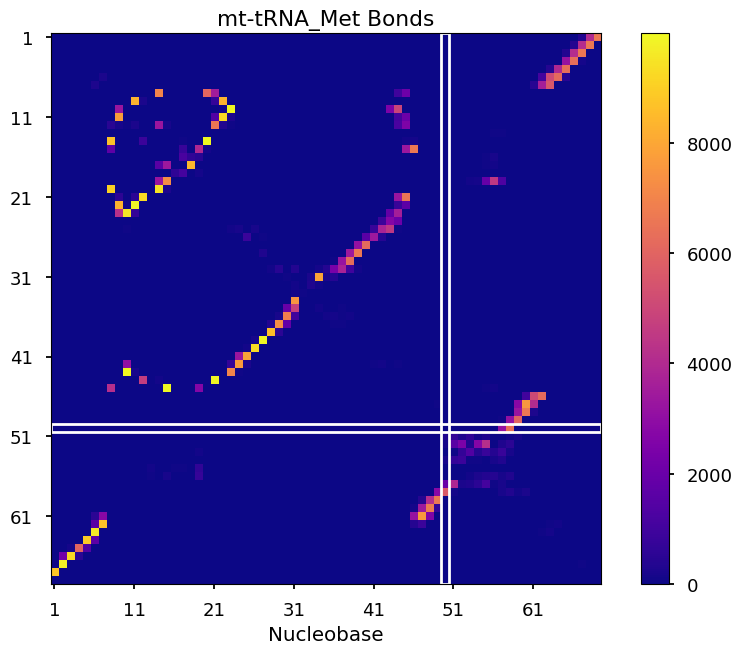

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


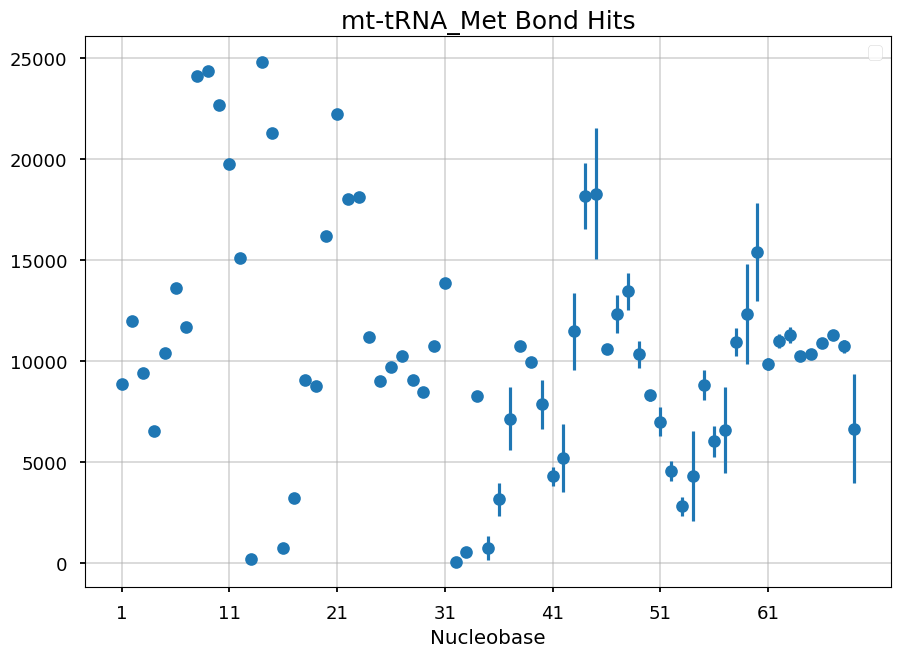

In [138]:
valm, valstd = basehit((rvecsval, rvecsval2, rvecsval3),
                      "mt-tRNA_Met", 
                      -.8, .8, -.8, .8)

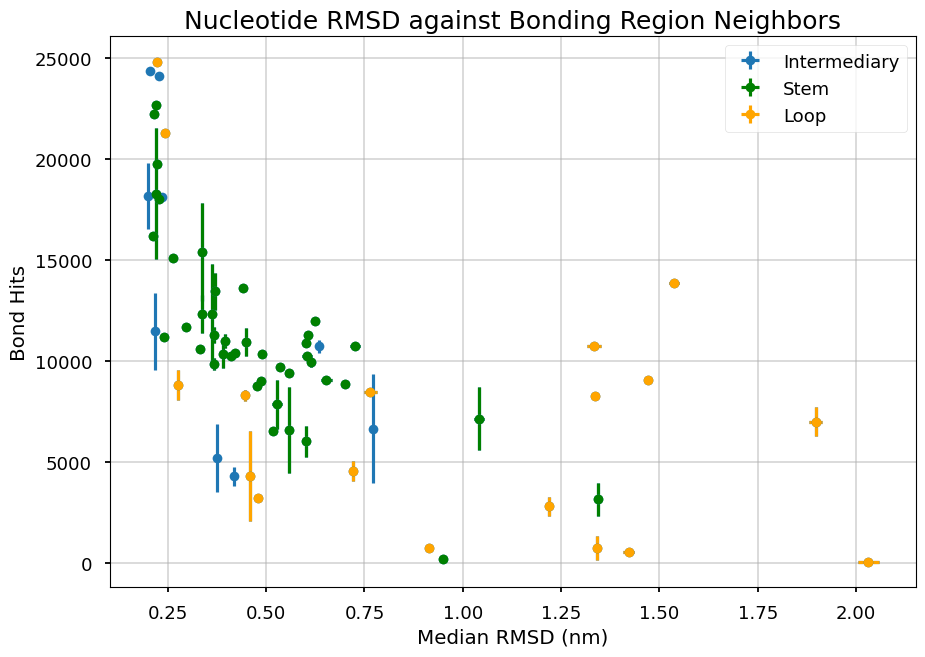

In [139]:
plt.errorbar(val_nuc_m,
            valm,
            xerr = val_nuc_std,
            yerr = valstd, 
            fmt = "o",
            markersize = 7,
            label = "Intermediary")

for i, sl in enumerate(stems):
    sl = sl.astype(int)
    plt.errorbar(val_nuc_m[sl],
        valm[sl],
        xerr = val_nuc_std[sl],
        yerr = valstd[sl], 
        fmt = "o",
        markersize = 7,
        label = "Stem",
        color = "green")
        
        
for i, sl in enumerate(loops):
    sl = sl.astype(int)
    plt.errorbar(val_nuc_m[sl],
        valm[sl],
        xerr = val_nuc_std[sl],
        yerr = valstd[sl], 
        fmt = "o",
        markersize = 7,
        label = "Loop",
        color = "orange")

plt.grid(alpha=.5)
plt.ylabel("Bond Hits")
plt.xlabel("Median RMSD (nm)")
plt.title("Nucleotide RMSD against Bonding Region Neighbors", fontsize = 18)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

## Lys Analysis

Base interactions to explore:
50; 48, 49, 51, 54, 56, 57

In [388]:
%cd ../lys/ 
!ls

/mnt/c/Users/cyber/Documents/Gromacs/atomistic/Newaim/lys
lys.28958.pdb	   lys.28958.pdb.output		lys.tar.gz   sim_70
lys.28958.pdb.gro  lys.28958.pdb.settings.used	lys_adj.pdb  sim_70_2
lys.28958.pdb.ndx  lys.28958.pdb.top		sim	     sim_70_3


In [389]:
nativelys = "lys.28958.pdb"
trajlys = "sim_70/tc_center.xtc"
toplys = "lys.28958.pdb.gro"
trajlys2 = "sim_70_2/tc_center.xtc"
trajlys3 = "sim_70_3/tc_center.xtc"

In [29]:
rvecslys, reslys = bb.dump_rvec(trajlys, topology=toplys, cutoff=100)
rvecslys2, reslys = bb.dump_rvec(trajlys2, topology=toplys, cutoff=100)
rvecslys3, reslys = bb.dump_rvec(trajlys3, topology=toplys, cutoff=100)

# Loading sim_70/tc_center.xtc 
# Loading sim_70_2/tc_center.xtc 
# Loading sim_70_3/tc_center.xtc 


In [390]:
rvecslysc, reslys = bb.dump_rvec(trajlys, topology=toplys, cutoff=3.5)
rvecslys2c, reslys = bb.dump_rvec(trajlys2, topology=toplys, cutoff=3.5)
rvecslys3c, reslys = bb.dump_rvec(trajlys3, topology=toplys, cutoff=3.5)

# Loading sim_70/tc_center.xtc 
# Loading sim_70_2/tc_center.xtc 
# Loading sim_70_3/tc_center.xtc 


In [40]:
ermsdlys = bb.ermsd(nativelys, trajlys, topology=toplys)
rmsdlys = bb.rmsd(nativelys,trajlys,topology=toplys,heavy_atom=False)

# Loaded reference lys.28958.pdb 
# Loaded target sim_70/tc_center.xtc 


# found  837 atoms in common


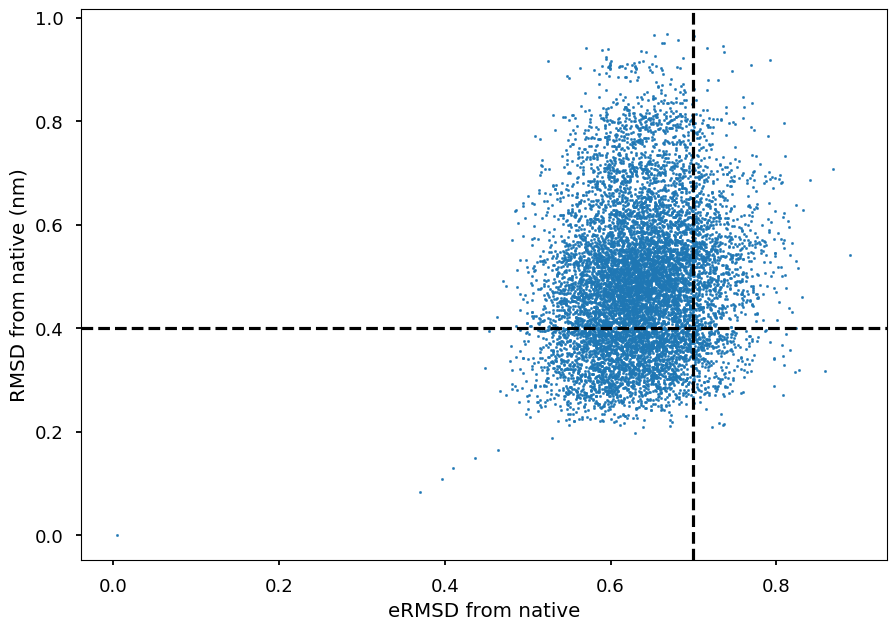

In [42]:
plt.xlabel("eRMSD from native")
plt.ylabel("RMSD from native (nm)")
plt.axhline(0.4,ls = "--", c= 'k')
plt.axvline(0.7,ls = "--", c= 'k')
plt.scatter(ermsdlys,rmsdlys,s=2.5)
plt.show()

/tmp/ipykernel_2212/3686272348.py:9: MatplotlibDeprecationWarning: Passing the radius parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  polygon = mpatches.RegularPolygon([0,0], 6, 0.28,fc='none',ec='k',lw=3,orientation=+np.pi/2)
/tmp/ipykernel_2212/3686272348.py:11: MatplotlibDeprecationWarning: Passing the radius parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  polygon = mpatches.RegularPolygon([-0.375,-0.225], 5, 0.24,fc='none',ec='k',lw=3,orientation=-0.42)


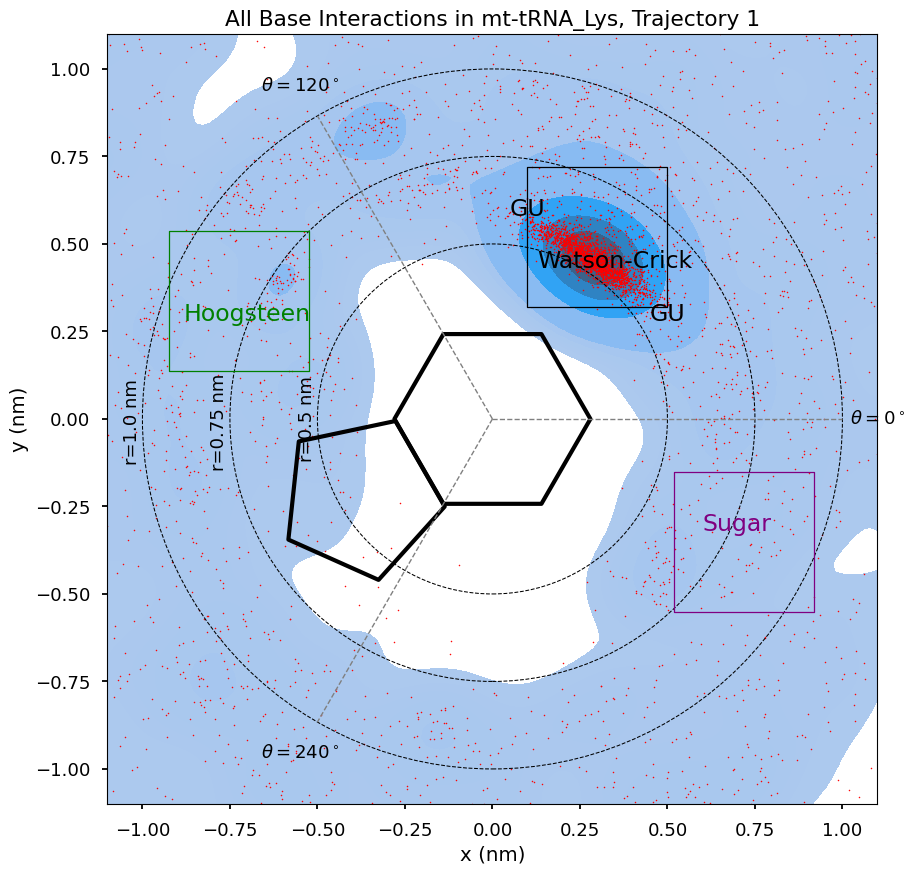

In [391]:
base_interaction_fullpicture_box("All Base Interactions in mt-tRNA_Lys, Trajectory 1", rvecslysc[::200])

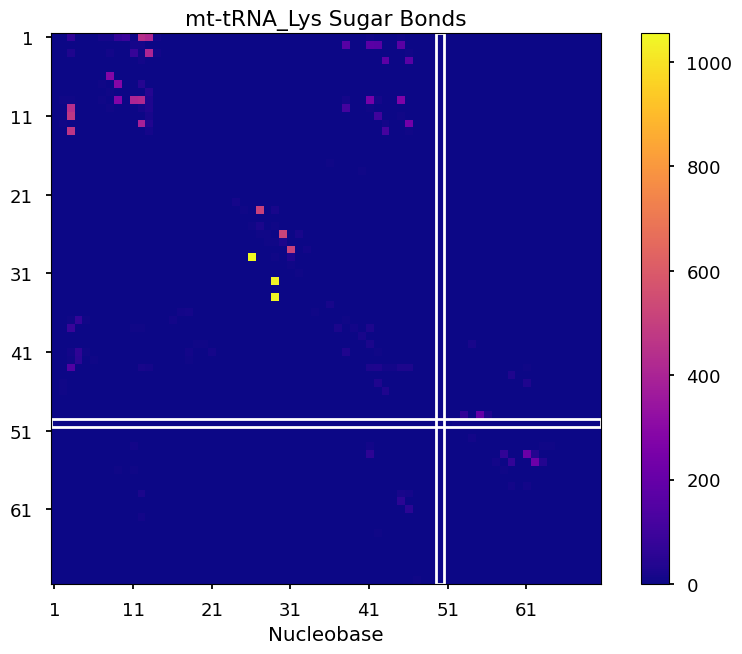

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


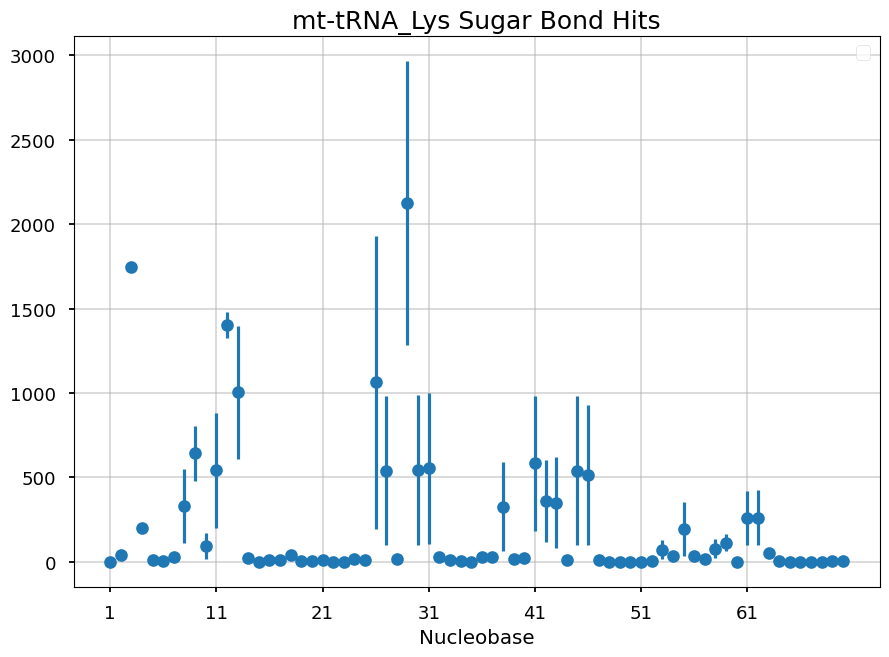

In [554]:
lyssugarm, lyssugarstd = basehit((rvecslysc, rvecslys2c, rvecslys3c),
                                     "mt-tRNA_Lys Sugar",
                                    x1s, x2s, y1s, y2s)

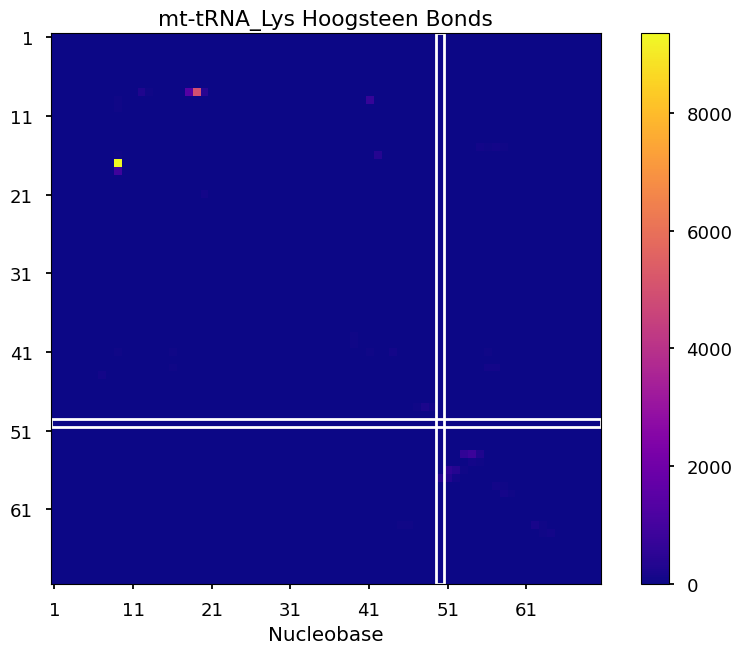

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


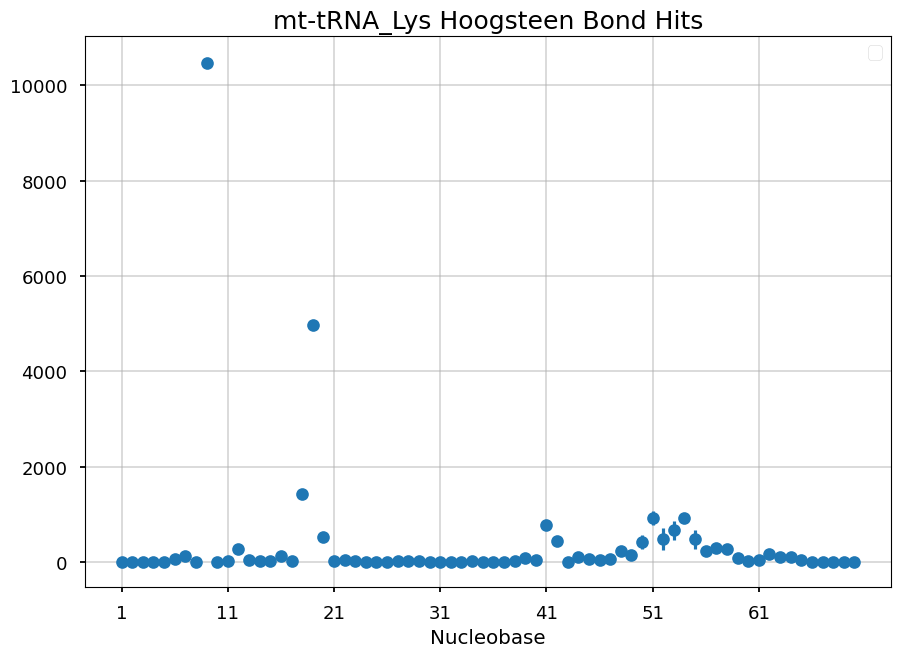

In [555]:
lyshoogm, lyshoogstd = basehit((rvecslysc, rvecslys2c, rvecslys3c),
                                     "mt-tRNA_Lys Hoogsteen",
                                    x1h, x2h, y1h, y2h)

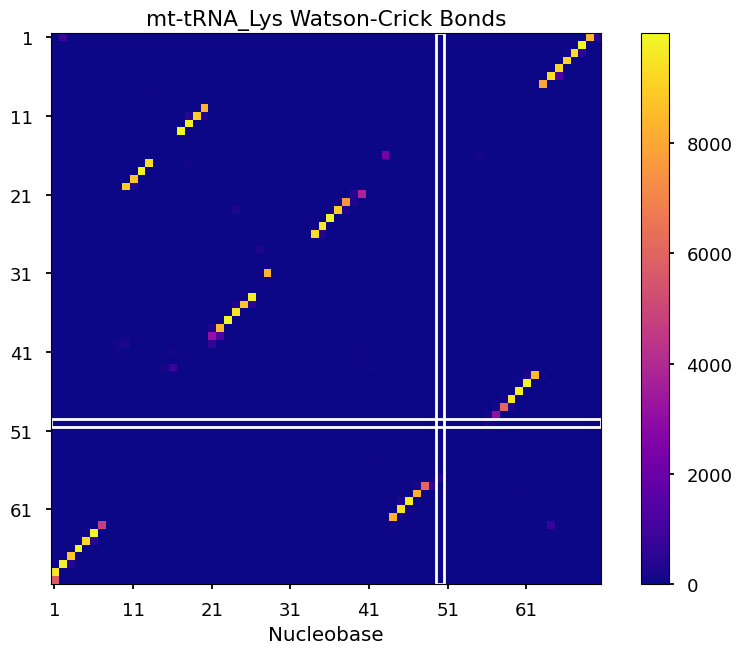

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


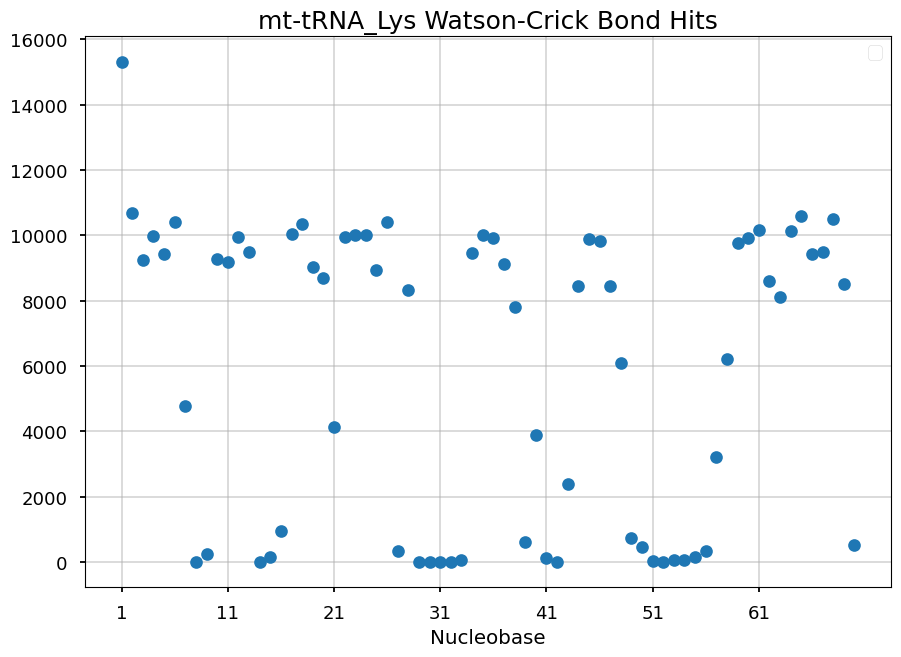

In [556]:
lysWCm, lysWCstd = basehit((rvecslysc, rvecslys2c, rvecslys3c),
                                     "mt-tRNA_Lys Watson-Crick",
                                    x1wc, x2wc, y1wc, y2wc)

## LysM Analysis

In [409]:
%cd ../lysM/
!ls

/mnt/c/Users/cyber/Documents/Gromacs/atomistic/Newaim/lysM
lysM.28957.pdb	    lysM.28957.pdb.output	  lysM.tar.gz	 sim_70
lysM.28957.pdb.gro  lysM.28957.pdb.settings.used  lys_M_adj.pdb  sim_70_2
lysM.28957.pdb.ndx  lysM.28957.pdb.top		  sim		 sim_70_3


In [411]:
nativelysM = "lysM.28957.pdb"
trajlysM = "sim_70/tc_center.xtc"
toplysM = "lysM.28957.pdb.gro"

trajlysM2 = "sim_70_2/tc_center.xtc"
trajlysM3 = "sim_70_3/tc_center.xtc"

In [39]:
rvecslysM, reslys = bb.dump_rvec(trajlysM, topology=toplysM, cutoff=100)
rvecslysM2, reslys = bb.dump_rvec(trajlysM2, topology=toplysM, cutoff=100)
rvecslysM3, reslys = bb.dump_rvec(trajlysM3, topology=toplysM, cutoff=100)

# Loading sim_70/tc_center.xtc 
# Loading sim_70_2/tc_center.xtc 
# Loading sim_70_3/tc_center.xtc 


In [412]:
rvecslysMc, reslys = bb.dump_rvec(trajlysM, topology=toplysM, cutoff=3.5)
rvecslysM2c, reslys = bb.dump_rvec(trajlysM2, topology=toplysM, cutoff=3.5)
rvecslysM3c, reslys = bb.dump_rvec(trajlysM3, topology=toplysM, cutoff=3.5)

# Loading sim_70/tc_center.xtc 
# Loading sim_70_2/tc_center.xtc 
# Loading sim_70_3/tc_center.xtc 


In [34]:
ermsdlysM = bb.ermsd(nativelysM, trajlysM, topology=toplysM)
rmsdlysM = bb.rmsd(nativelysM,trajlysM,topology=toplysM,heavy_atom=False)

# Loaded reference lysM.28957.pdb 
# Loaded target sim_70/tc_center.xtc 


# found  837 atoms in common


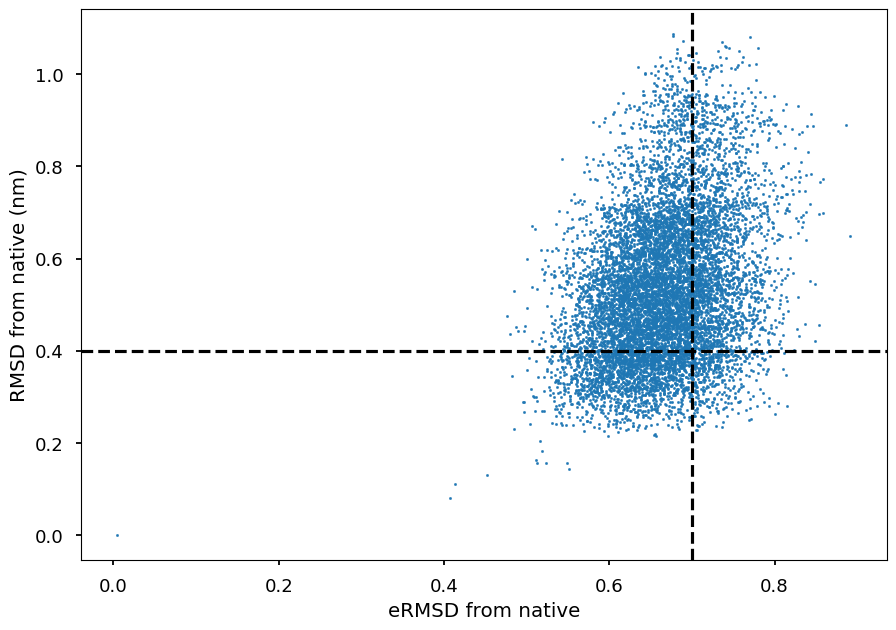

In [35]:

plt.xlabel("eRMSD from native")
plt.ylabel("RMSD from native (nm)")
plt.axhline(0.4,ls = "--", c= 'k')
plt.axvline(0.7,ls = "--", c= 'k')
plt.scatter(ermsdlysM,rmsdlysM,s=2.5)
plt.show()

/tmp/ipykernel_2212/3686272348.py:9: MatplotlibDeprecationWarning: Passing the radius parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  polygon = mpatches.RegularPolygon([0,0], 6, 0.28,fc='none',ec='k',lw=3,orientation=+np.pi/2)
/tmp/ipykernel_2212/3686272348.py:11: MatplotlibDeprecationWarning: Passing the radius parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  polygon = mpatches.RegularPolygon([-0.375,-0.225], 5, 0.24,fc='none',ec='k',lw=3,orientation=-0.42)


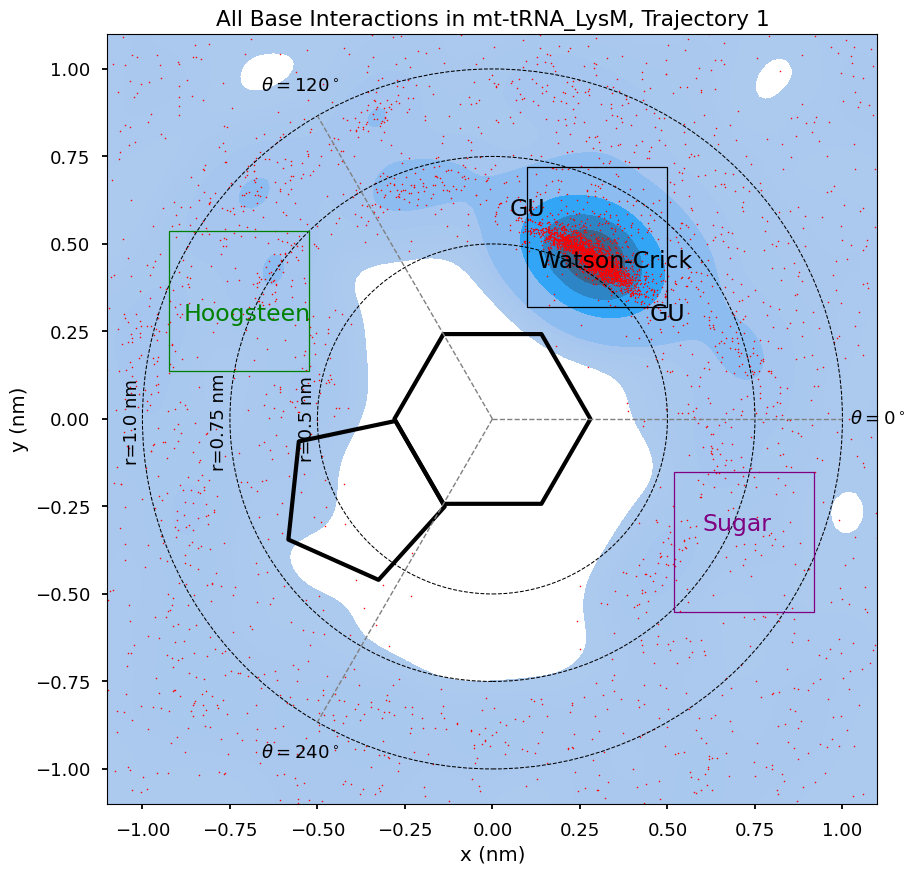

In [413]:
base_interaction_fullpicture_box("All Base Interactions in mt-tRNA_LysM, Trajectory 1", rvecslysMc[::200])

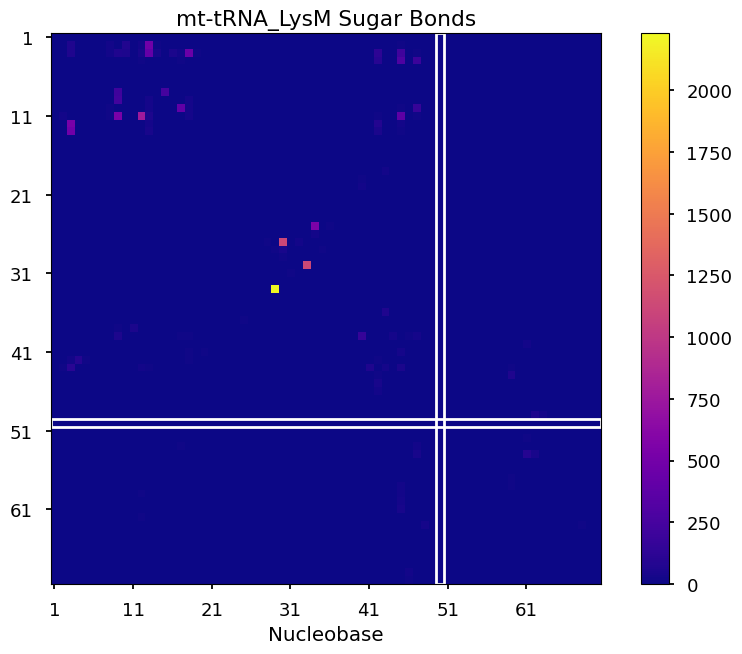

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


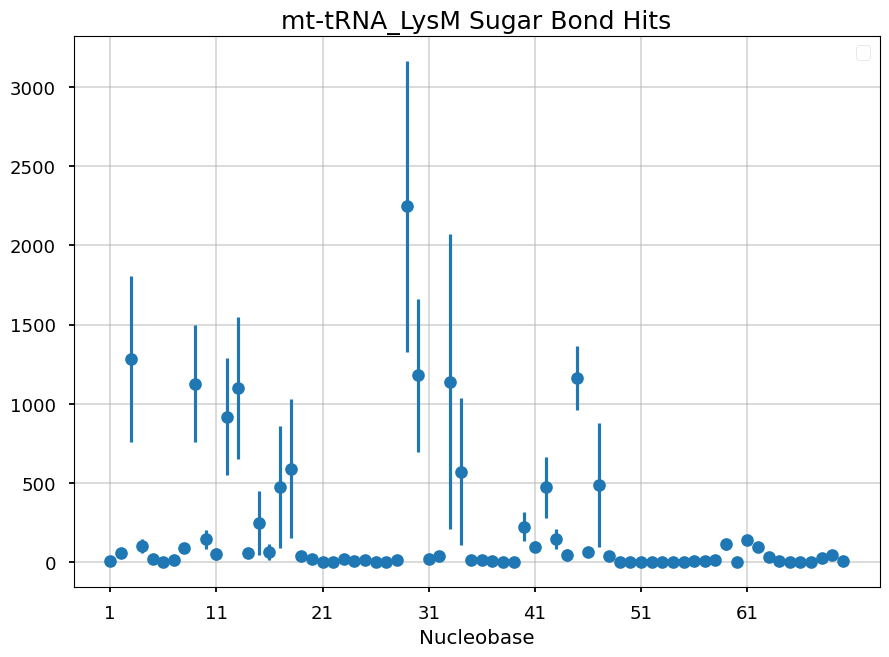

In [557]:
lysMsugarm, lysMsugarstd = basehit((rvecslysMc, rvecslysM2c, rvecslysM3c),
                                     "mt-tRNA_LysM Sugar",
                                    x1s, x2s, y1s, y2s)

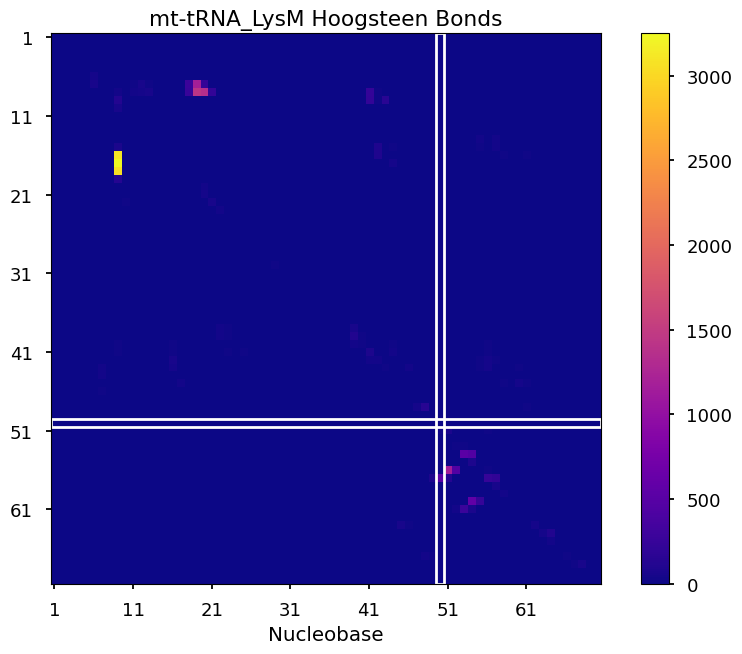

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


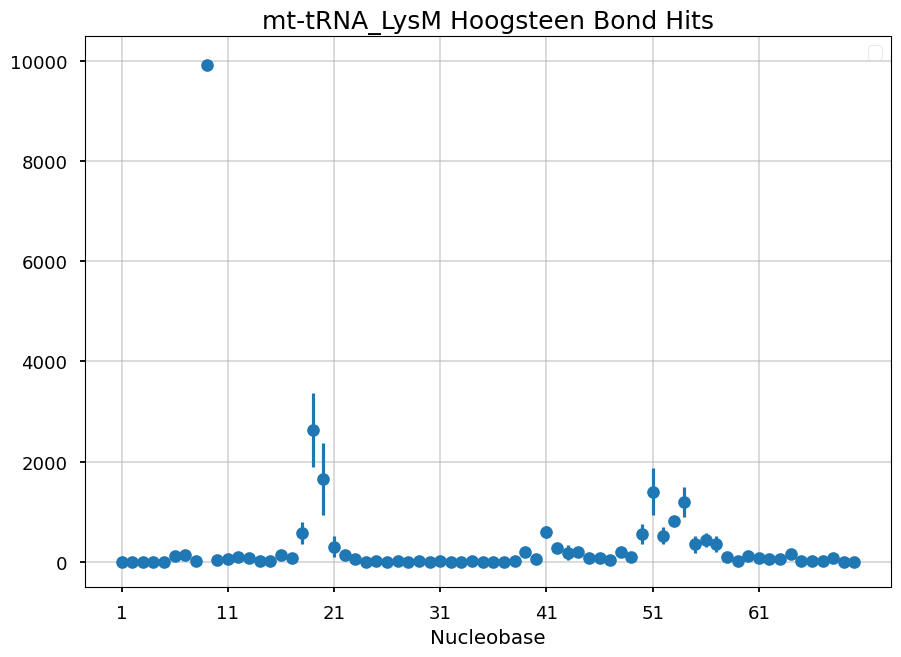

In [558]:
lysMhoogm, lysMhoogstd = basehit((rvecslysMc, rvecslysM2c, rvecslysM3c),
                                     "mt-tRNA_LysM Hoogsteen",
                                    x1h, x2h, y1h, y2h)

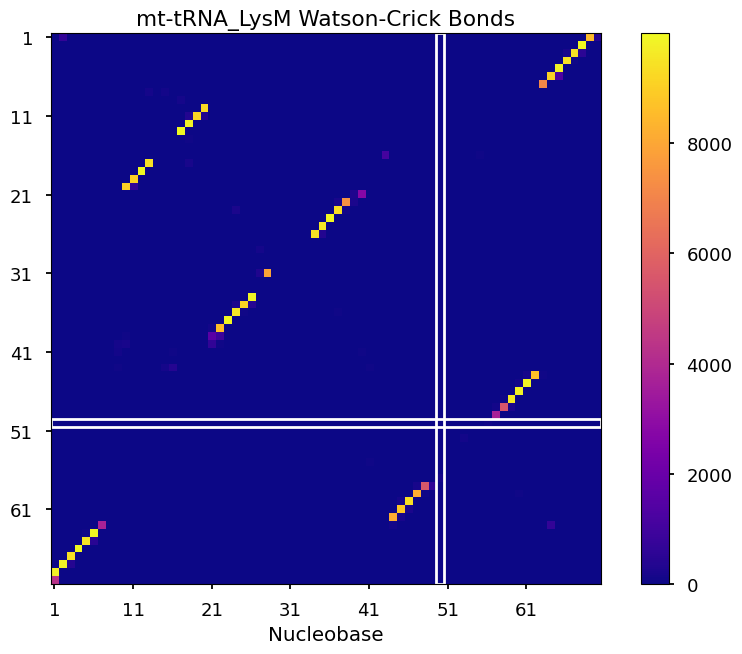

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


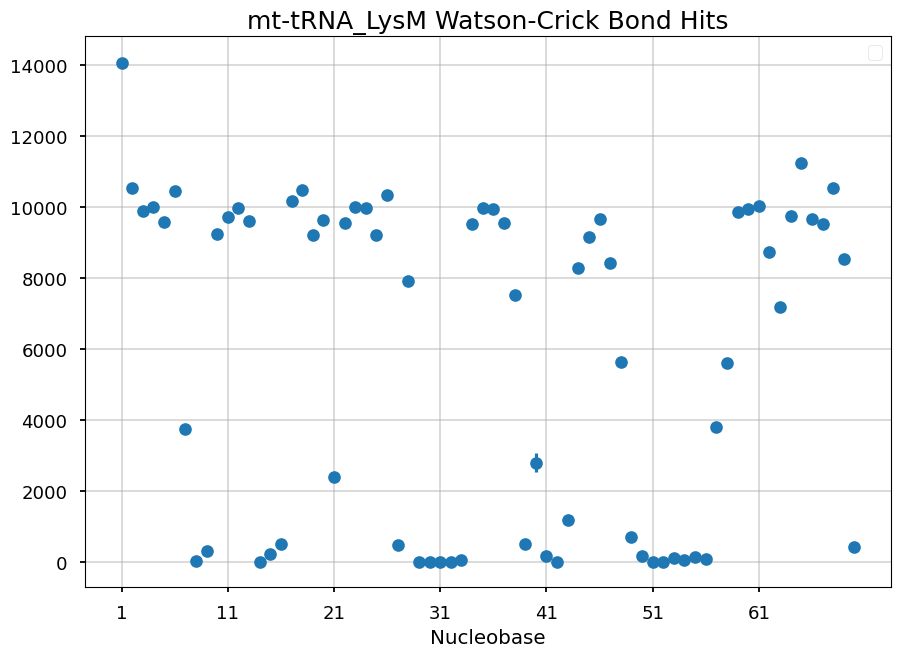

In [559]:
lysMWCm, lysMWCstd = basehit((rvecslysMc, rvecslysM2c, rvecslysM3c),
                                     "mt-tRNA_LysM Watson-Crick",
                                    x1wc, x2wc, y1wc, y2wc)

## Leu Analysis

In [169]:
%cd ../leu/
!ls

/mnt/c/Users/cyber/Documents/Gromacs/atomistic/Newaim/leu
leu.28963.pdb	      leu.28963.pdb.settings.used  leu.pdb	    sim_70
leu.28963.pdb.gro     leu.28963.pdb.top		   leu_adj.pdb	    sim_70_2
leu.28963.pdb.ndx     leu.28963_metmatch.pdb	   leu_adj_noH.pdb  sim_70_3
leu.28963.pdb.output  leu.28963_valmatch.pdb	   sim


In [170]:
nativeleu = "leu.28963.pdb"
trajleu = "sim_70/tc_center.xtc"
topleu = "leu.28963.pdb.gro"
trajleu2 = "sim_70_2/tc_center.xtc"
trajleu3 = "sim_70_3/tc_center.xtc"


In [49]:
ermsdleu = bb.ermsd(nativeleu, trajleu, topology=topleu)
rmsdleu = bb.rmsd(nativeleu,trajleu,topology=topleu,heavy_atom=False)

# Loaded reference leu.28963.pdb 
# Loaded target sim_70/tc_center.xtc 


# found  897 atoms in common


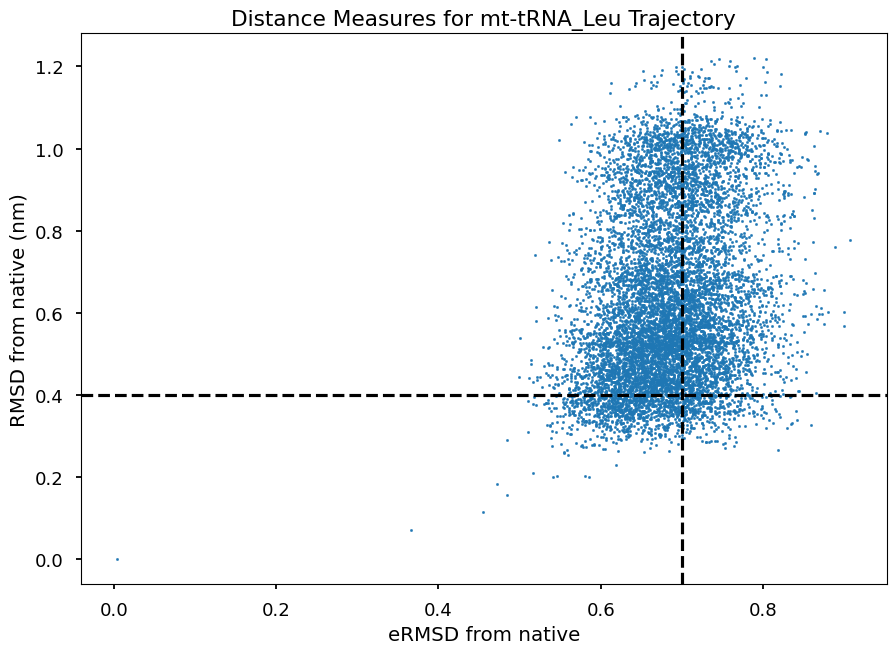

In [53]:
plt.xlabel("eRMSD from native")
plt.ylabel("RMSD from native (nm)")
plt.axhline(0.4,ls = "--", c= 'k')
plt.axvline(0.7,ls = "--", c= 'k')
plt.title(f"Distance Measures for mt-tRNA_Leu Trajectory")
plt.scatter(ermsdleu,rmsdleu,s=2.5)
plt.show()

In [172]:
rvecsleuc, resleu = bb.dump_rvec(trajleu, topology=topleu, cutoff=3.5)
rvecsleu2c, resleu = bb.dump_rvec(trajleu2, topology=topleu, cutoff=3.5)
rvecsleu3c, resleu = bb.dump_rvec(trajleu3, topology=topleu, cutoff=3.5)

# Loading sim_70/tc_center.xtc 
# Loading sim_70_2/tc_center.xtc 
# Loading sim_70_3/tc_center.xtc 


In [19]:
rvecsleu, resleu = bb.dump_rvec(trajleu, topology=topleu, cutoff=100)
rvecsleu2, resleu = bb.dump_rvec(trajleu2, topology=topleu, cutoff=100)
rvecsleu3, resleu = bb.dump_rvec(trajleu3, topology=topleu, cutoff=100)

# Loading sim_70/tc_center.xtc 
# Loading sim_70_2/tc_center.xtc 
# Loading sim_70_3/tc_center.xtc 


/tmp/ipykernel_2212/3686272348.py:9: MatplotlibDeprecationWarning: Passing the radius parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  polygon = mpatches.RegularPolygon([0,0], 6, 0.28,fc='none',ec='k',lw=3,orientation=+np.pi/2)
/tmp/ipykernel_2212/3686272348.py:11: MatplotlibDeprecationWarning: Passing the radius parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  polygon = mpatches.RegularPolygon([-0.375,-0.225], 5, 0.24,fc='none',ec='k',lw=3,orientation=-0.42)


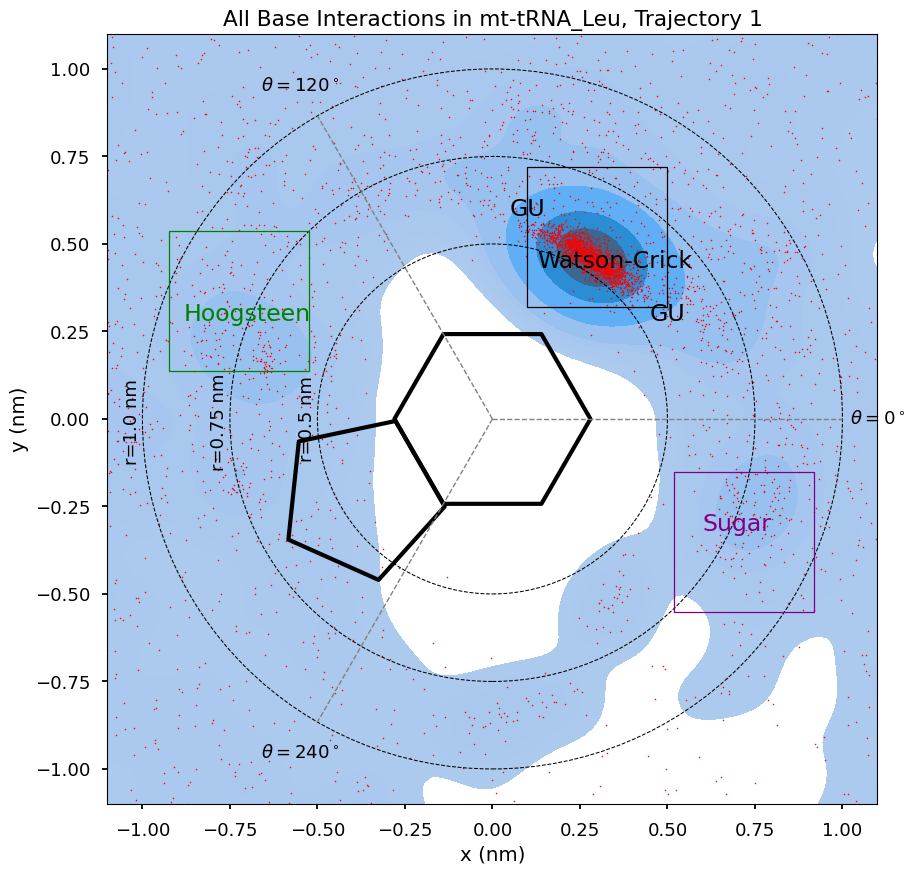

In [386]:
base_interaction_fullpicture_box("All Base Interactions in mt-tRNA_Leu, Trajectory 1", rvecsleuc[::200])

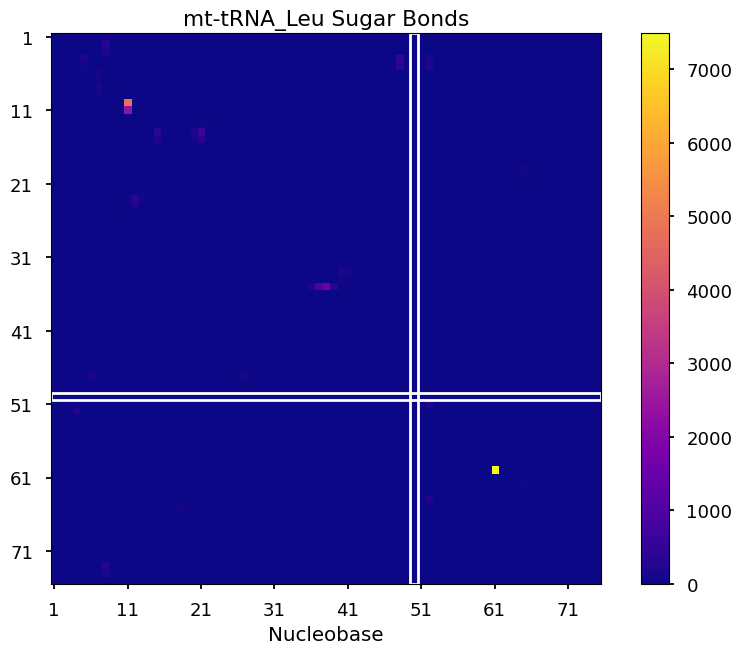

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


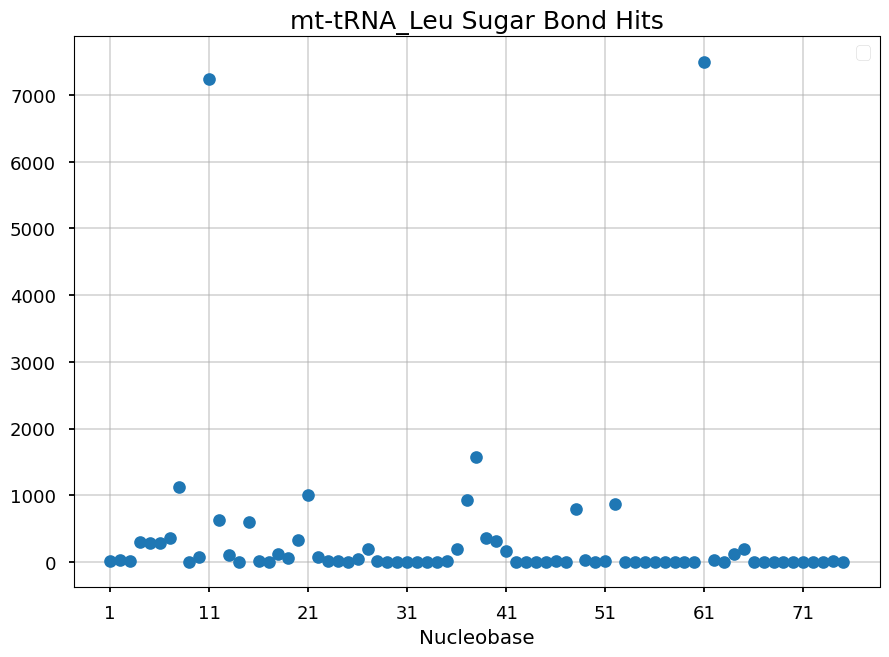

In [177]:
leusugarm, leusugarstd = basehit((rvecsleuc, rvecsleu2c, rvecsleu3c),
                                     "mt-tRNA_Leu Sugar",
                                    x1s, x2s, y1s, y2s) 

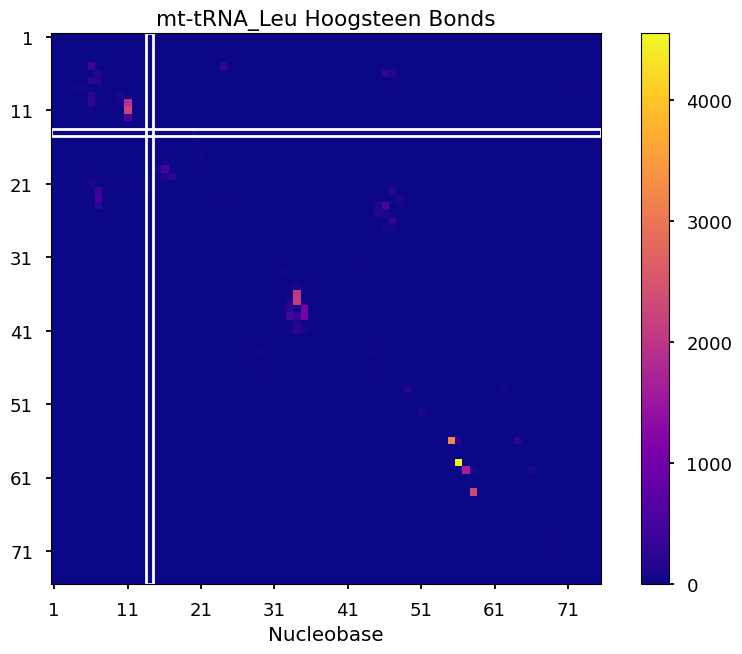

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


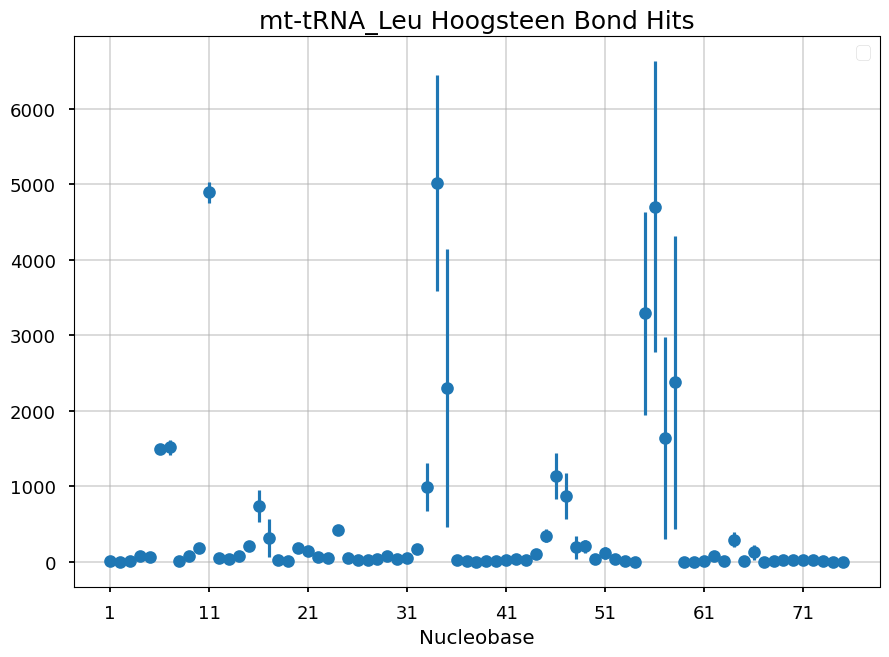

In [443]:
leuhoogm, leuhoogstd = basehit((rvecsleuc, rvecsleu2c, rvecsleu3c),
                                     "mt-tRNA_Leu Hoogsteen",
                                    x1h, x2h, y1h, y2h)

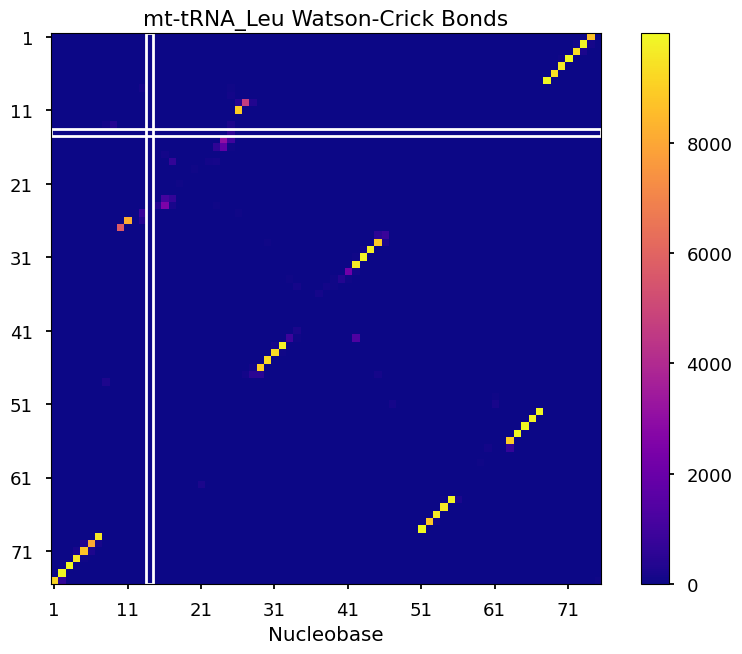

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


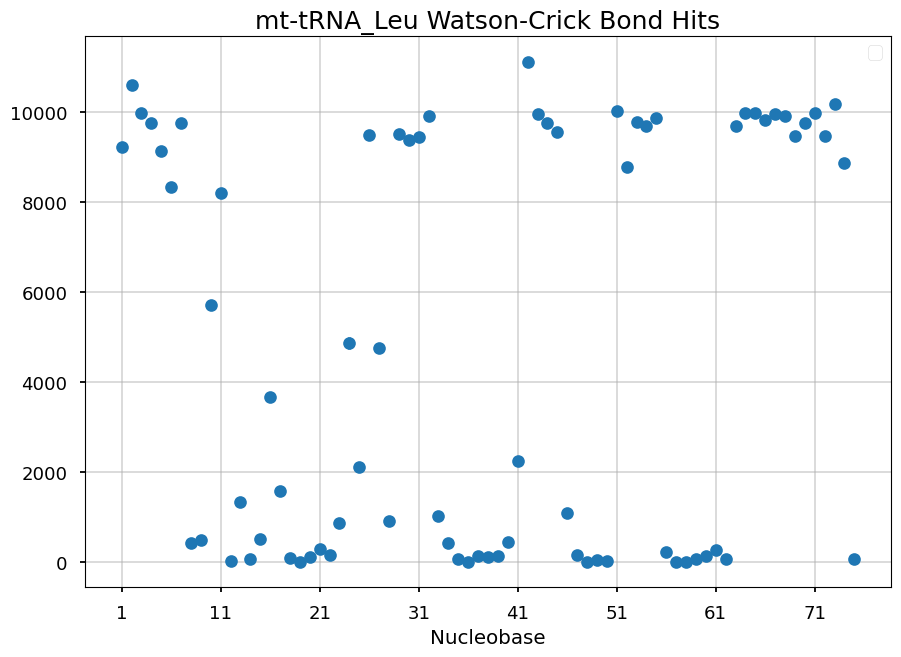

In [444]:
leuWCm, leuWCstd = basehit((rvecsleuc, rvecsleu2c, rvecsleu3c),
                                     "mt-tRNA_Leu Watson-Crick",
                                    x1wc, x2wc, y1wc, y2wc)

## LeuM Analysis

In [73]:
%cd ../leuM/
!ls

/mnt/c/Users/cyber/Documents/Gromacs/atomistic/Newaim/leuM
leuM.28964.pdb	       leuM.28964.pdb.settings.used  leuM_adj_noH.pdb  sim_70_3
leuM.28964.pdb.gro     leuM.28964.pdb.top	     sim
leuM.28964.pdb.ndx     leuM.pdb			     sim_70
leuM.28964.pdb.output  leuM_adj.pdb		     sim_70_2


In [74]:
nativeleuM = "leuM.28964.pdb"
trajleuM = "sim_70/tc_center.xtc"
topleuM = "leuM.28964.pdb.gro"
trajleuM2 = "sim_70_2/tc_center.xtc"
trajleuM3 = "sim_70_3/tc_center.xtc"

In [ ]:
rvecsleuM, resleuM = bb.dump_rvec(trajleuM, topology=topleuM, cutoff=100)
rvecsleuM2, resleuM = bb.dump_rvec(trajleuM2, topology=topleuM, cutoff=100)
rvecsleuM3, resleuM = bb.dump_rvec(trajleuM3, topology=topleuM, cutoff=100)

In [45]:
ermsdleuM = bb.ermsd(nativeleuM, trajleuM, topology=topleuM)
rmsdleuM = bb.rmsd(nativeleuM,trajleuM,topology=topleuM,heavy_atom=False)

# Loaded reference leuM.28964.pdb 
# Loaded target sim_70/tc_center.xtc 


# found  897 atoms in common


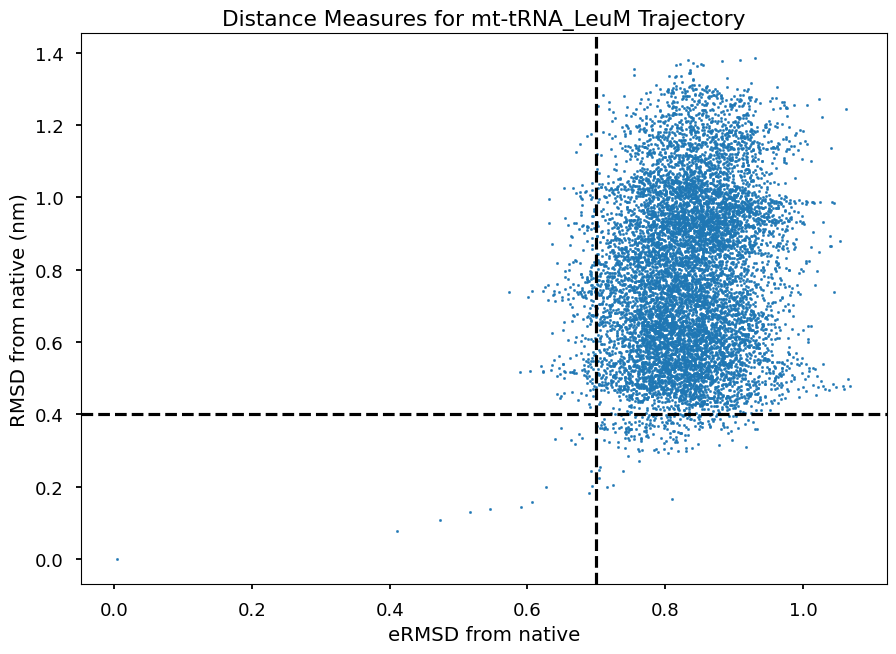

In [52]:

plt.xlabel("eRMSD from native")
plt.ylabel("RMSD from native (nm)")
plt.axhline(0.4,ls = "--", c= 'k')
plt.axvline(0.7,ls = "--", c= 'k')
plt.title("Distance Measures for mt-tRNA_LeuM Trajectory")
plt.scatter(ermsdleuM,rmsdleuM,s=2.5)
plt.show()

In [66]:
rvecsoriginal, res = bb.dump_rvec(trajleuM, topology=topleuM, cutoff=3.5)

# Loading sim_70/tc_center.xtc 


In [67]:
rvecs = rvecsoriginal[::200]

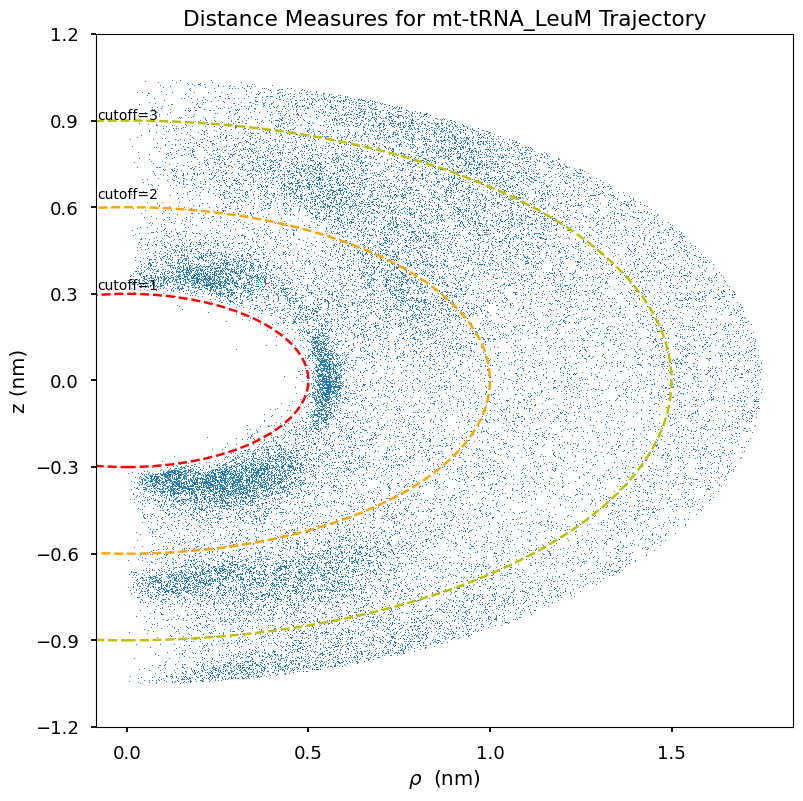

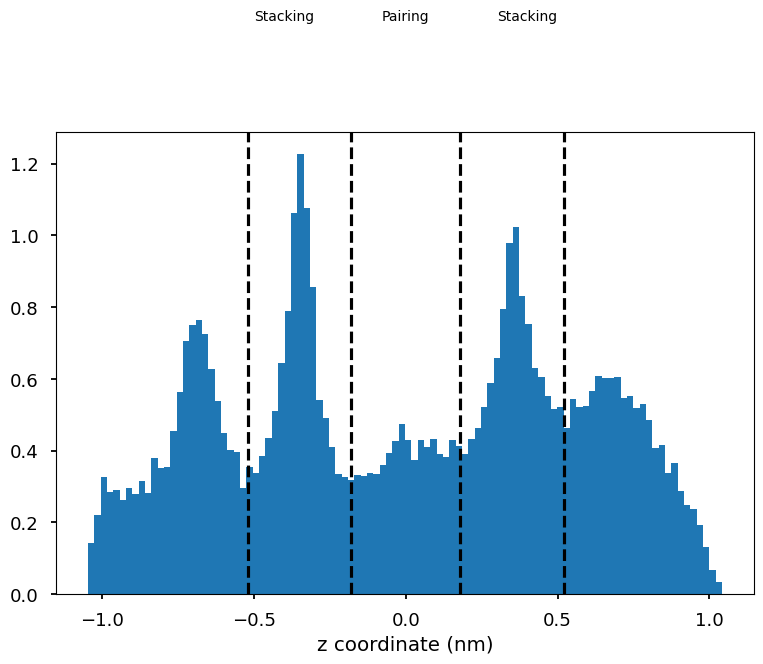

/tmp/ipykernel_994/501438991.py:53: MatplotlibDeprecationWarning: Passing the radius parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  polygon = mpatches.RegularPolygon([0,0], 6, 0.28,fc='none',ec='k',lw=3,orientation=+np.pi/2)
/tmp/ipykernel_994/501438991.py:55: MatplotlibDeprecationWarning: Passing the radius parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  polygon = mpatches.RegularPolygon([-0.375,-0.225], 5, 0.24,fc='none',ec='k',lw=3,orientation=-0.42)


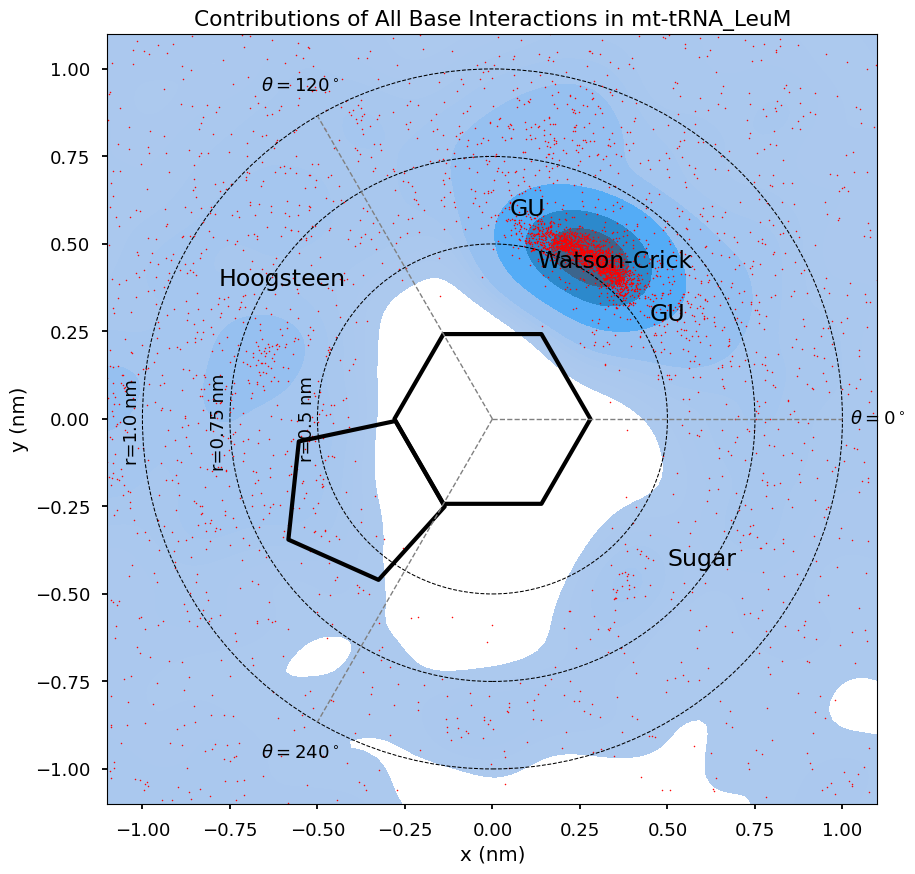

In [68]:
base_interaction_counts("mt-tRNA_LeuM", rvecs)

In [186]:
rvecsoriginal, resleuM = bb.dump_rvec(trajleuM, topology=topleuM, cutoff=100)
rvecsleuM = rvecsoriginal[::]

# Loading sim_70/tc_center.xtc 


In [196]:
rvecsleuM2, resleuM = bb.dump_rvec(trajleuM2, topology=topleuM, cutoff=100)
rvecsleuM3, resleuM = bb.dump_rvec(trajleuM3, topology=topleuM, cutoff=100)

# Loading sim_70_2/tc_center.xtc 
# Loading sim_70_3/tc_center.xtc 


In [76]:
rvecsleuMc, resleuM = bb.dump_rvec(trajleuM, topology=topleuM, cutoff=3.5)
rvecsleuM2c, resleuM = bb.dump_rvec(trajleuM2, topology=topleuM, cutoff=3.5)
rvecsleuM3c, resleuM = bb.dump_rvec(trajleuM3, topology=topleuM, cutoff=3.5)

# Loading sim_70/tc_center.xtc 
# Loading sim_70_2/tc_center.xtc 
# Loading sim_70_3/tc_center.xtc 


In [22]:
nonzero = np.where(np.sum(rvecsleuMc**2, axis=3)>0.01)
test = rvecsleuMc[nonzero]

/tmp/ipykernel_2212/3686272348.py:9: MatplotlibDeprecationWarning: Passing the radius parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  polygon = mpatches.RegularPolygon([0,0], 6, 0.28,fc='none',ec='k',lw=3,orientation=+np.pi/2)
/tmp/ipykernel_2212/3686272348.py:11: MatplotlibDeprecationWarning: Passing the radius parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  polygon = mpatches.RegularPolygon([-0.375,-0.225], 5, 0.24,fc='none',ec='k',lw=3,orientation=-0.42)


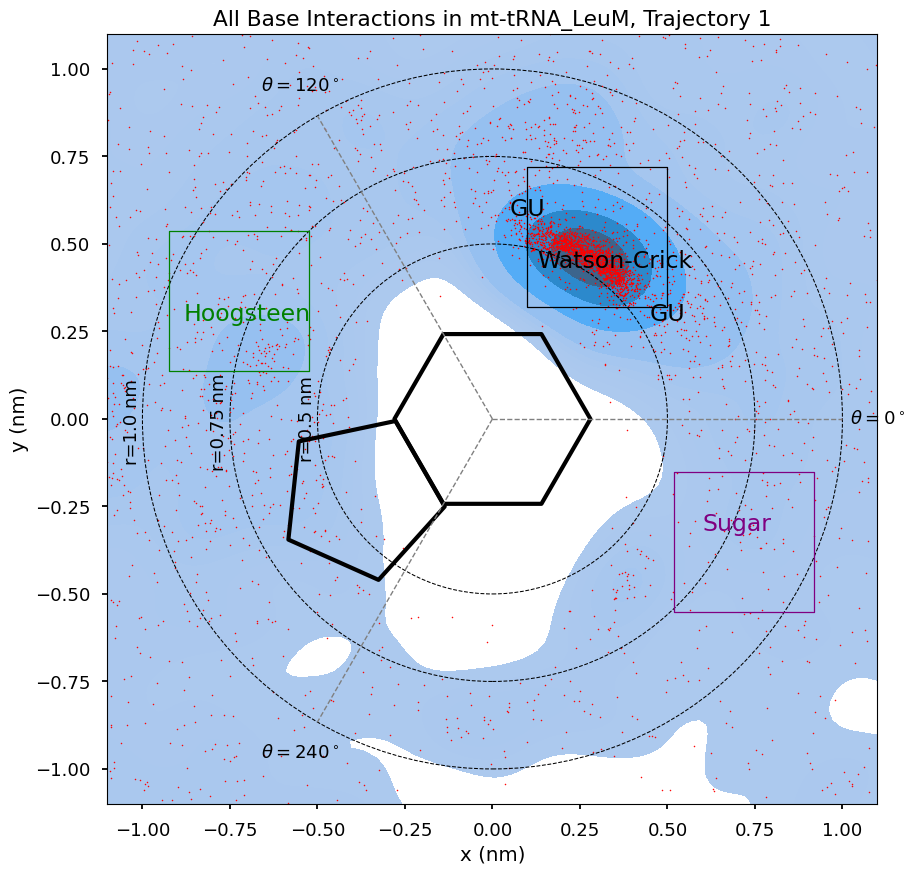

In [387]:
base_interaction_fullpicture_box("All Base Interactions in mt-tRNA_LeuM, Trajectory 1", rvecsleuMc[::200])

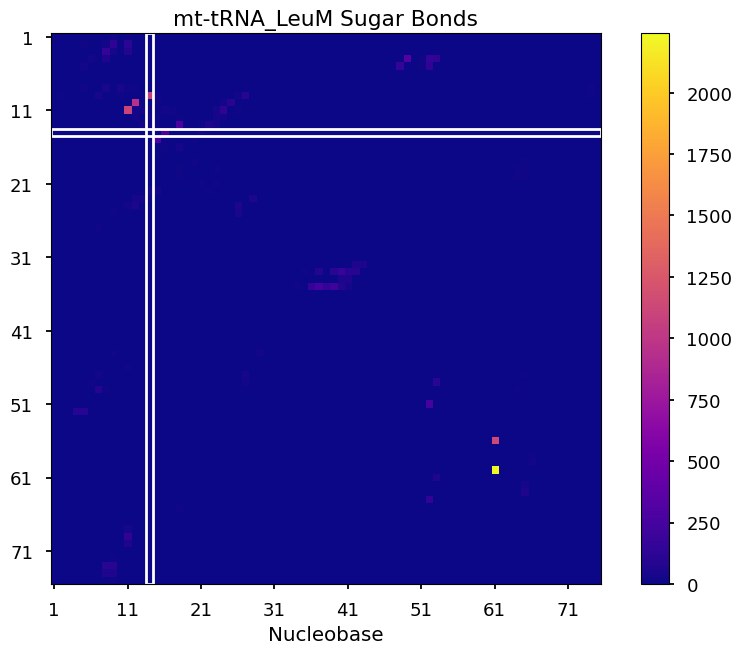

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


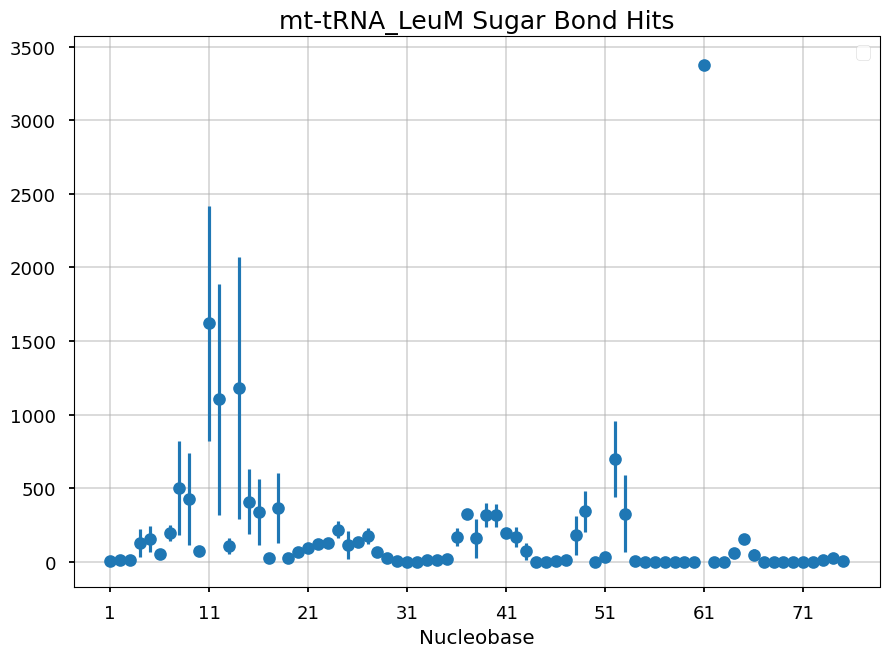

In [453]:
leuMsugarm, leuMsugarstd = basehit((rvecsleuMc, rvecsleuM2c, rvecsleuM3c),
                                     "mt-tRNA_LeuM Sugar",
                                    x1s, x2s, y1s, y2s) 

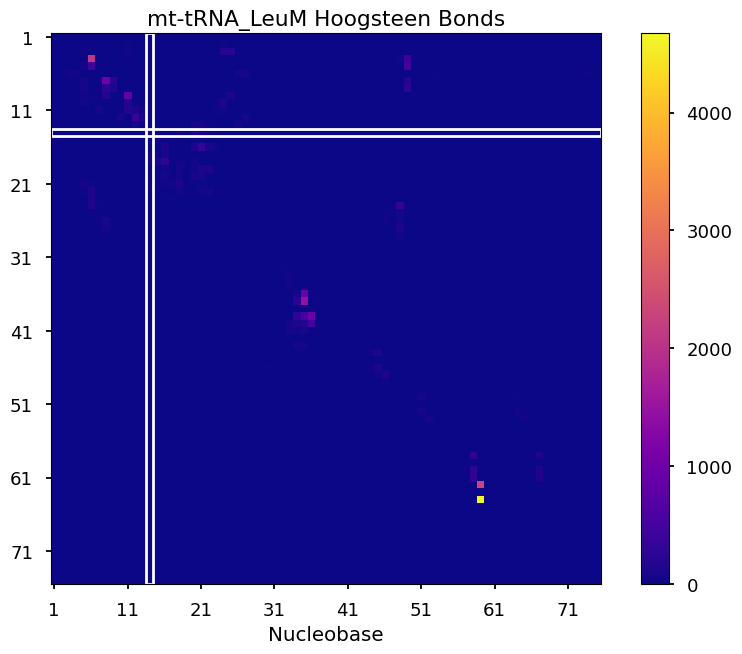

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


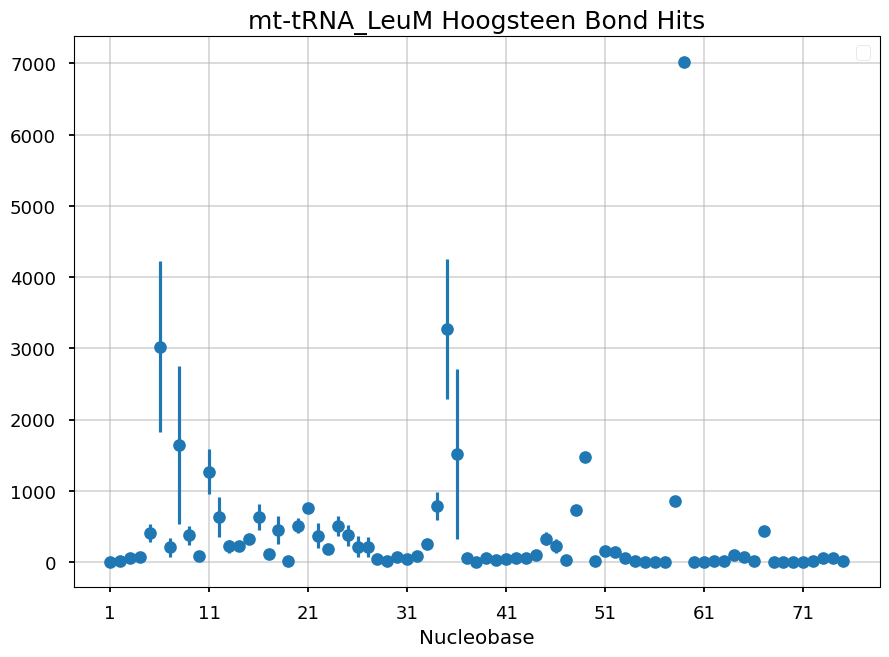

In [448]:
leuMhoogm, leuMhoogstd = basehit((rvecsleuMc, rvecsleuM2c, rvecsleuM3c),
                                     "mt-tRNA_LeuM Hoogsteen",
                                    x1h, x2h, y1h, y2h) 

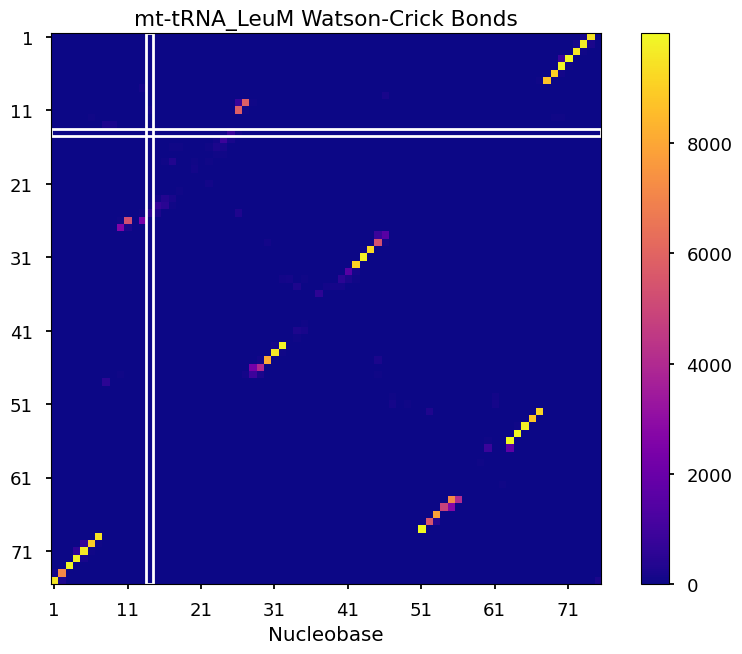

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


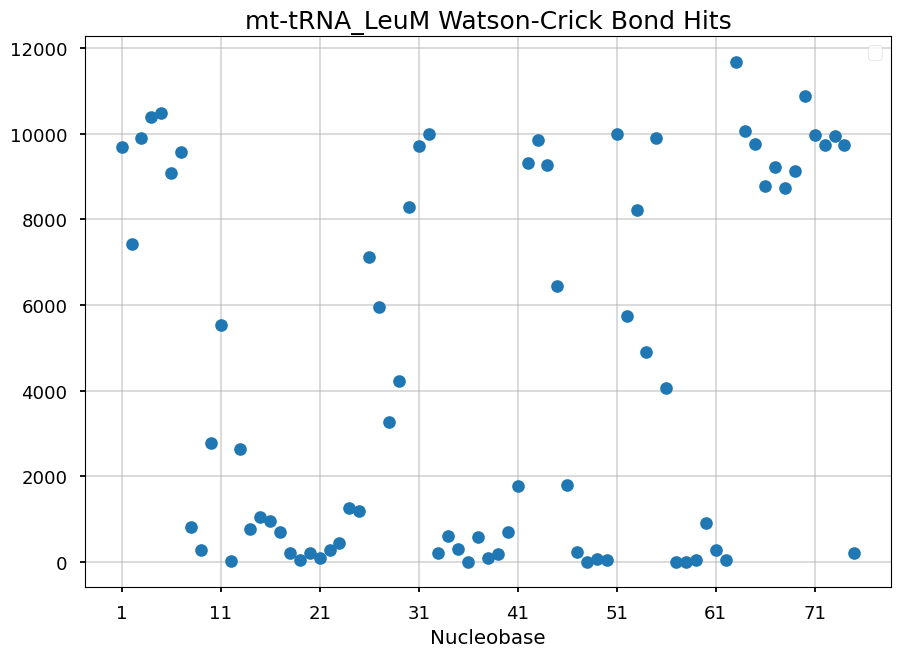

In [449]:
leuMWCm, leuMWCstd = basehit((rvecsleuMc, rvecsleuM2c, rvecsleuM3c),
                                     "mt-tRNA_LeuM Watson-Crick",
                                    x1wc, x2wc, y1wc, y2wc) 

## Cross-Comparison

Text(0.5, 1.0, 'mt-tRNA_Leu Base 14 and 13 Interaction')

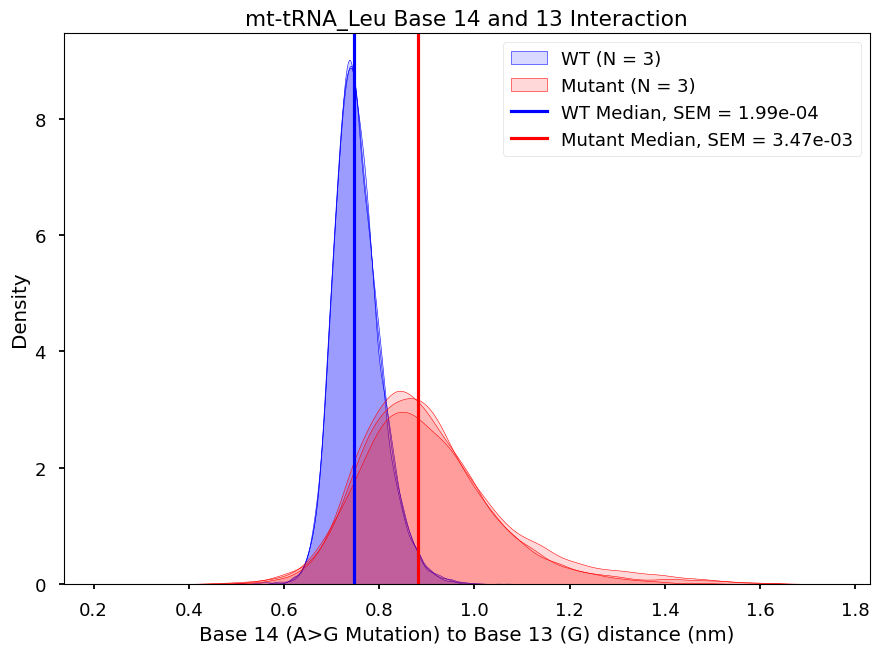

In [253]:
b1 = 13
b2 = 12
a = .15
color1, color2 = "blue", "red"
dist = np.sqrt(np.sum(rvecs[:,b1,b2]**2,axis=1))
data1 = np.sqrt(np.sum(rvecsleu[:,b1,b2]**2,axis=1))
data2 = np.sqrt(np.sum(rvecsleu2[:,b1,b2]**2,axis=1))
data3 = np.sqrt(np.sum(rvecsleu3[:,b1,b2]**2,axis=1))
sns.kdeplot(data1, color = color1, alpha = a, fill=True, label = "WT (N = 3)")
sns.kdeplot(data2, color = color1, alpha = a, fill=True)
sns.kdeplot(data3, color = color1, alpha = a, fill=True)
avg_med1 = np.mean((np.median(data1), np.median(data2), np.median(data3)))
SEM_med1 = np.std((np.median(data1), np.median(data2), np.median(data3))) / np.sqrt(3)

data4 = np.sqrt(np.sum(rvecsleuM[:,b1,b2]**2,axis=1))
data5 = np.sqrt(np.sum(rvecsleuM2[:,b1,b2]**2,axis=1))
data6 = np.sqrt(np.sum(rvecsleuM3[:,b1,b2]**2,axis=1))
sns.kdeplot(data4, color = color2, alpha = a, fill=True, label = "Mutant (N = 3)")
sns.kdeplot(data5, color = color2, alpha = a, fill=True)
sns.kdeplot(data6, color = color2, alpha = a, fill=True)
avg_med2 = np.mean((np.median(data4), np.median(data5), np.median(data6)))
SEM_med2 = np.std((np.median(data4), np.median(data5), np.median(data6))) / np.sqrt(3)

plt.axvline(avg_med1, c = color1,
            label = f"WT Median, SEM = {np.format_float_scientific(SEM_med1, exp_digits=2, precision=2)}")
plt.axvline(avg_med2, c = color2, label = f"Mutant Median, SEM = {np.format_float_scientific(SEM_med2, exp_digits=2, precision=2)}")

plt.legend()
plt.xlabel(f"Base {b1+1} (A>G Mutation) to Base {b2+1} ({resleu[b2][:-5]}) distance (nm)")
plt.title(f"mt-tRNA_Leu Base {b1+1} and {b2+1} Interaction")


Text(0.5, 1.0, 'mt-tRNA_Leu Base 14 and 15 Interaction')

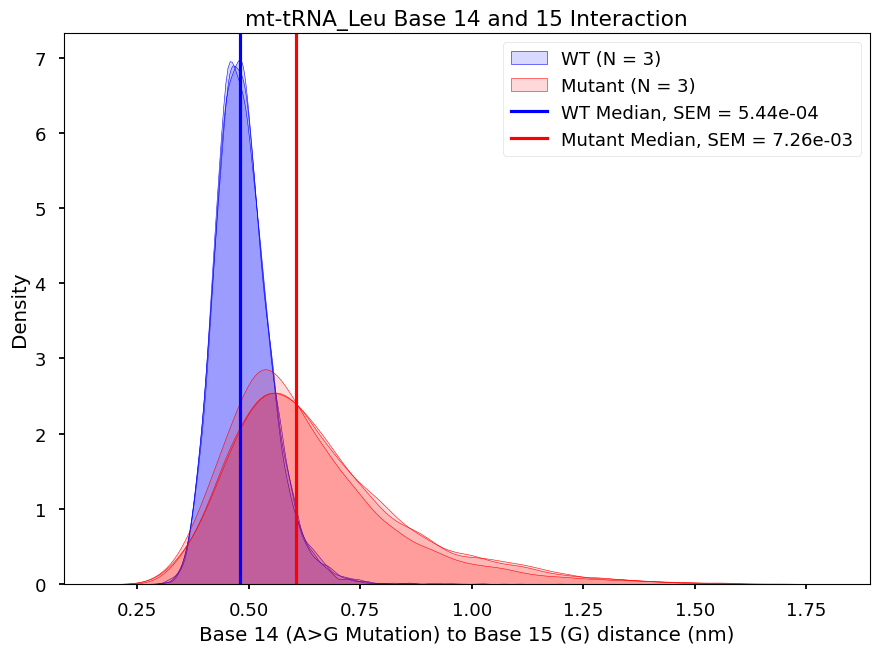

In [254]:
b1 = 13
b2 = 14
a = .15
color1, color2 = "blue", "red"
dist = np.sqrt(np.sum(rvecs[:,b1,b2]**2,axis=1))
data1 = np.sqrt(np.sum(rvecsleu[:,b1,b2]**2,axis=1))
data2 = np.sqrt(np.sum(rvecsleu2[:,b1,b2]**2,axis=1))
data3 = np.sqrt(np.sum(rvecsleu3[:,b1,b2]**2,axis=1))
sns.kdeplot(data1, color = color1, alpha = a, fill=True, label = "WT (N = 3)")
sns.kdeplot(data2, color = color1, alpha = a, fill=True)
sns.kdeplot(data3, color = color1, alpha = a, fill=True)
avg_med1 = np.mean((np.median(data1), np.median(data2), np.median(data3)))
SEM_med1 = np.std((np.median(data1), np.median(data2), np.median(data3))) / np.sqrt(3)

data4 = np.sqrt(np.sum(rvecsleuM[:,b1,b2]**2,axis=1))
data5 = np.sqrt(np.sum(rvecsleuM2[:,b1,b2]**2,axis=1))
data6 = np.sqrt(np.sum(rvecsleuM3[:,b1,b2]**2,axis=1))
sns.kdeplot(data4, color = color2, alpha = a, fill=True, label = "Mutant (N = 3)")
sns.kdeplot(data5, color = color2, alpha = a, fill=True)
sns.kdeplot(data6, color = color2, alpha = a, fill=True)
avg_med2 = np.mean((np.median(data4), np.median(data5), np.median(data6)))
SEM_med2 = np.std((np.median(data4), np.median(data5), np.median(data6))) / np.sqrt(3)

plt.axvline(avg_med1, c = color1,
            label = f"WT Median, SEM = {np.format_float_scientific(SEM_med1, exp_digits=2, precision=2)}")
plt.axvline(avg_med2, c = color2, label = f"Mutant Median, SEM = {np.format_float_scientific(SEM_med2, exp_digits=2, precision=2)}")

plt.legend()
plt.xlabel(f"Base {b1+1} (A>G Mutation) to Base {b2+1} ({resleu[b2][:-5]}) distance (nm)")
plt.title(f"mt-tRNA_Leu Base {b1+1} and {b2+1} Interaction")


Text(0.5, 1.0, 'mt-tRNA_Leu Base 14 and 16 Interaction')

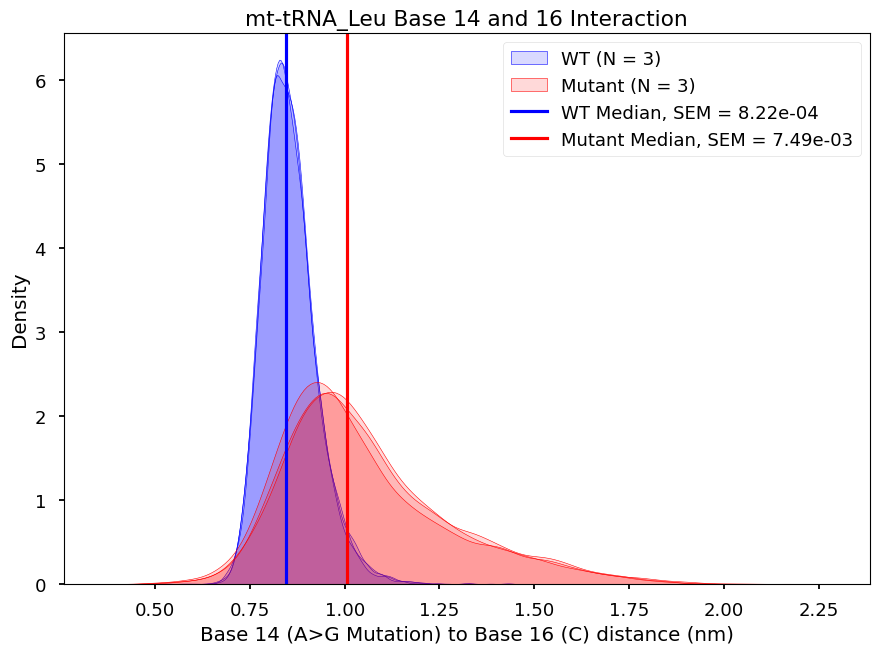

In [255]:
b1 = 13
b2 = 15
a = .15
color1, color2 = "blue", "red"
dist = np.sqrt(np.sum(rvecs[:,b1,b2]**2,axis=1))
data1 = np.sqrt(np.sum(rvecsleu[:,b1,b2]**2,axis=1))
data2 = np.sqrt(np.sum(rvecsleu2[:,b1,b2]**2,axis=1))
data3 = np.sqrt(np.sum(rvecsleu3[:,b1,b2]**2,axis=1))
sns.kdeplot(data1, color = color1, alpha = a, fill=True, label = "WT (N = 3)")
sns.kdeplot(data2, color = color1, alpha = a, fill=True)
sns.kdeplot(data3, color = color1, alpha = a, fill=True)
avg_med1 = np.mean((np.median(data1), np.median(data2), np.median(data3)))
SEM_med1 = np.std((np.median(data1), np.median(data2), np.median(data3))) / np.sqrt(3)

data4 = np.sqrt(np.sum(rvecsleuM[:,b1,b2]**2,axis=1))
data5 = np.sqrt(np.sum(rvecsleuM2[:,b1,b2]**2,axis=1))
data6 = np.sqrt(np.sum(rvecsleuM3[:,b1,b2]**2,axis=1))
sns.kdeplot(data4, color = color2, alpha = a, fill=True, label = "Mutant (N = 3)")
sns.kdeplot(data5, color = color2, alpha = a, fill=True)
sns.kdeplot(data6, color = color2, alpha = a, fill=True)
avg_med2 = np.mean((np.median(data4), np.median(data5), np.median(data6)))
SEM_med2 = np.std((np.median(data4), np.median(data5), np.median(data6))) / np.sqrt(3)

plt.axvline(avg_med1, c = color1,
            label = f"WT Median, SEM = {np.format_float_scientific(SEM_med1, exp_digits=2, precision=2)}")
plt.axvline(avg_med2, c = color2, label = f"Mutant Median, SEM = {np.format_float_scientific(SEM_med2, exp_digits=2, precision=2)}")

plt.legend()
plt.xlabel(f"Base {b1+1} (A>G Mutation) to Base {b2+1} ({resleu[b2][:-5]}) distance (nm)")
plt.title(f"mt-tRNA_Leu Base {b1+1} and {b2+1} Interaction")


Text(0.5, 1.0, 'mt-tRNA_Leu Base 14 and 17 Interaction')

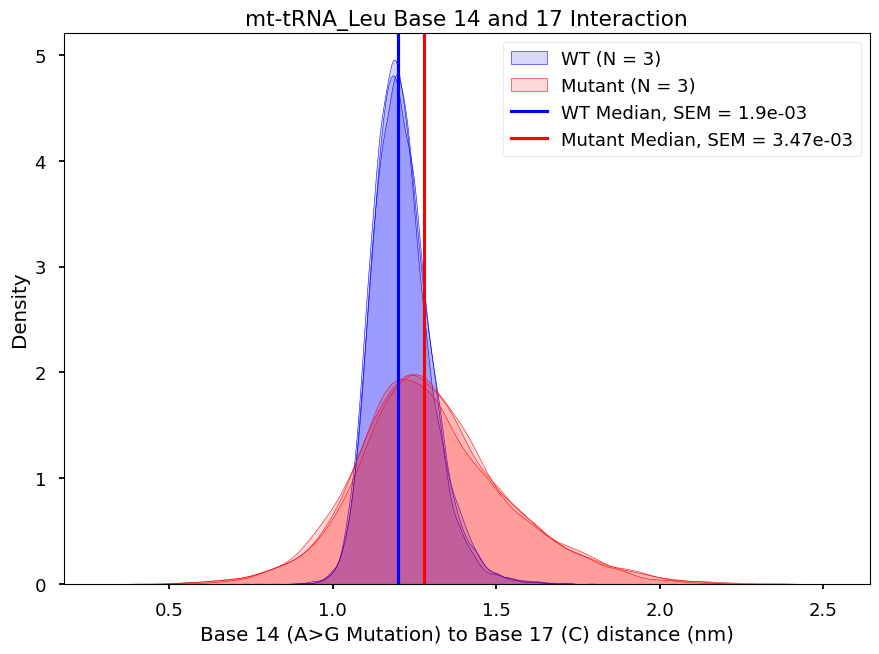

In [262]:
b1 = 13
b2 = 16
a = .15
color1, color2 = "blue", "red"
dist = np.sqrt(np.sum(rvecs[:,b1,b2]**2,axis=1))
data1 = np.sqrt(np.sum(rvecsleu[:,b1,b2]**2,axis=1))
data2 = np.sqrt(np.sum(rvecsleu2[:,b1,b2]**2,axis=1))
data3 = np.sqrt(np.sum(rvecsleu3[:,b1,b2]**2,axis=1))
sns.kdeplot(data1, color = color1, alpha = a, fill=True, label = "WT (N = 3)")
sns.kdeplot(data2, color = color1, alpha = a, fill=True)
sns.kdeplot(data3, color = color1, alpha = a, fill=True)
avg_med1 = np.mean((np.median(data1), np.median(data2), np.median(data3)))
SEM_med1 = np.std((np.median(data1), np.median(data2), np.median(data3))) / np.sqrt(3)

data4 = np.sqrt(np.sum(rvecsleuM[:,b1,b2]**2,axis=1))
data5 = np.sqrt(np.sum(rvecsleuM2[:,b1,b2]**2,axis=1))
data6 = np.sqrt(np.sum(rvecsleuM3[:,b1,b2]**2,axis=1))
sns.kdeplot(data4, color = color2, alpha = a, fill=True, label = "Mutant (N = 3)")
sns.kdeplot(data5, color = color2, alpha = a, fill=True)
sns.kdeplot(data6, color = color2, alpha = a, fill=True)
avg_med2 = np.mean((np.median(data4), np.median(data5), np.median(data6)))
SEM_med2 = np.std((np.median(data4), np.median(data5), np.median(data6))) / np.sqrt(3)

plt.axvline(avg_med1, c = color1,
            label = f"WT Median, SEM = {np.format_float_scientific(SEM_med1, exp_digits=2, precision=2)}")
plt.axvline(avg_med2, c = color2, label = f"Mutant Median, SEM = {np.format_float_scientific(SEM_med2, exp_digits=2, precision=2)}")

plt.legend()
plt.xlabel(f"Base {b1+1} (A>G Mutation) to Base {b2+1} ({resleu[b2][:-5]}) distance (nm)")
plt.title(f"mt-tRNA_Leu Base {b1+1} and {b2+1} Interaction")


Text(0.5, 1.0, 'mt-tRNA_Leu Base 14 and 25 Interaction')

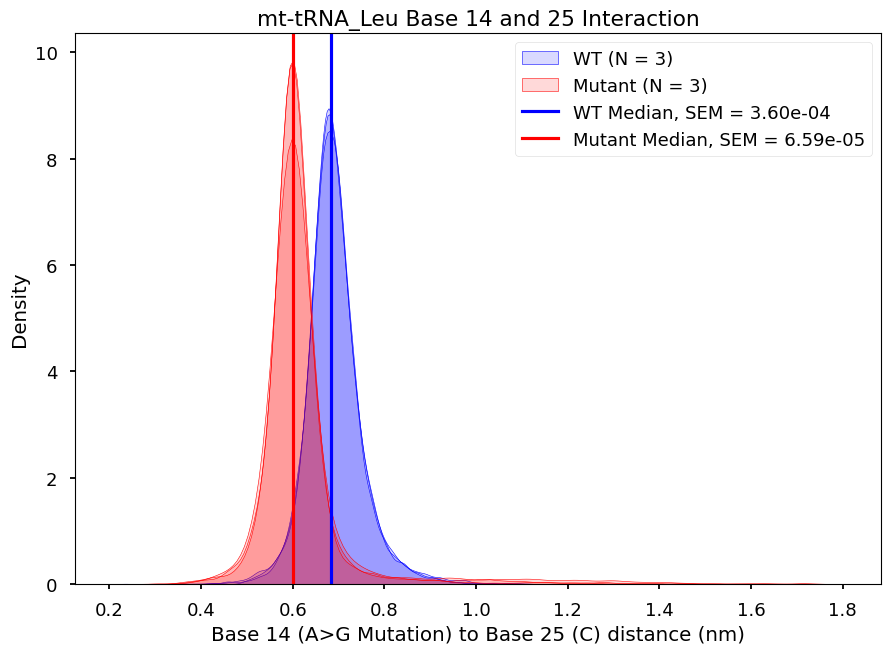

In [79]:
b1 = 13
b2 = 24
a = .15
color1, color2 = "blue", "red"
data1 = np.sqrt(np.sum(rvecsleuc[:,b1,b2]**2,axis=1))
data2 = np.sqrt(np.sum(rvecsleu2c[:,b1,b2]**2,axis=1))
data3 = np.sqrt(np.sum(rvecsleu3c[:,b1,b2]**2,axis=1))
sns.kdeplot(data1, color = color1, alpha = a, fill=True, label = "WT (N = 3)")
sns.kdeplot(data2, color = color1, alpha = a, fill=True)
sns.kdeplot(data3, color = color1, alpha = a, fill=True)
avg_med1 = np.mean((np.median(data1), np.median(data2), np.median(data3)))
SEM_med1 = np.std((np.median(data1), np.median(data2), np.median(data3))) / np.sqrt(3)

data4 = np.sqrt(np.sum(rvecsleuMc[:,b1,b2]**2,axis=1))
data5 = np.sqrt(np.sum(rvecsleuM2c[:,b1,b2]**2,axis=1))
data6 = np.sqrt(np.sum(rvecsleuM3c[:,b1,b2]**2,axis=1))
sns.kdeplot(data4[data4>.01], color = color2, alpha = a, fill=True, label = "Mutant (N = 3)")
sns.kdeplot(data5[data5>.01], color = color2, alpha = a, fill=True)
sns.kdeplot(data6[data6>.01], color = color2, alpha = a, fill=True)
avg_med2 = np.mean((np.median(data4), np.median(data5), np.median(data6)))
SEM_med2 = np.std((np.median(data4), np.median(data5), np.median(data6))) / np.sqrt(3)

plt.axvline(avg_med1, c = color1,
            label = f"WT Median, SEM = {np.format_float_scientific(SEM_med1, exp_digits=2, precision=2)}")
plt.axvline(avg_med2, c = color2, label = f"Mutant Median, SEM = {np.format_float_scientific(SEM_med2, exp_digits=2, precision=2)}")

plt.legend()
plt.xlabel(f"Base {b1+1} (A>G Mutation) to Base {b2+1} ({resleu[b2][:-5]}) distance (nm)")
plt.title(f"mt-tRNA_Leu Base {b1+1} and {b2+1} Interaction")


Text(0.5, 1.0, 'mt-tRNA_Leu Base 14 and 17 Interaction')

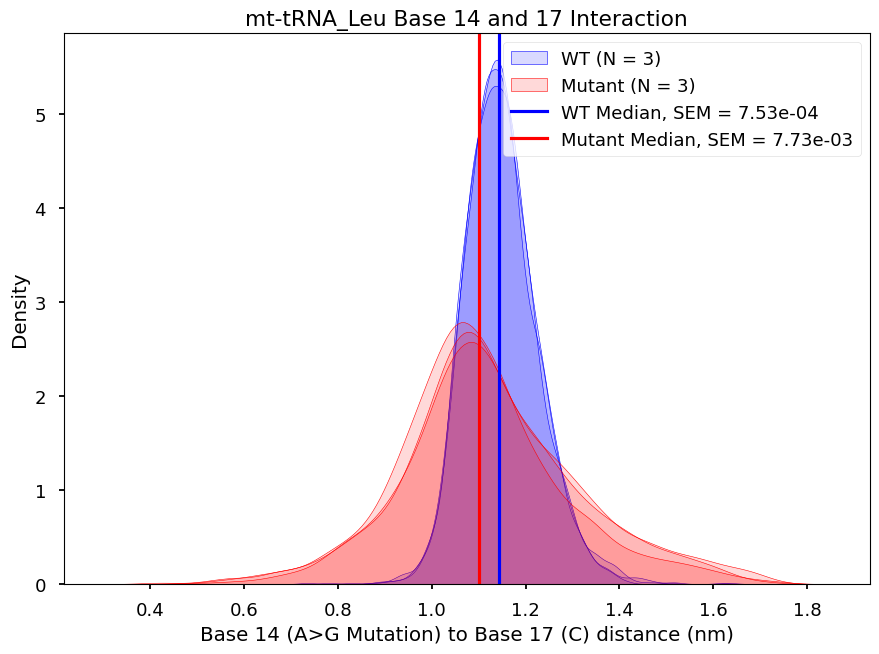

In [82]:
b1 = 13
b2 = 16
a = .15
color1, color2 = "blue", "red"
data1 = np.sqrt(np.sum(rvecsleuc[:,b1,b2]**2,axis=1))
data2 = np.sqrt(np.sum(rvecsleu2c[:,b1,b2]**2,axis=1))
data3 = np.sqrt(np.sum(rvecsleu3c[:,b1,b2]**2,axis=1))
data1 = data1[data1>.01]
data2 = data2[data2>.01]
data3 = data3[data3>.01]
sns.kdeplot(data1, color = color1, alpha = a, fill=True, label = "WT (N = 3)")
sns.kdeplot(data2, color = color1, alpha = a, fill=True)
sns.kdeplot(data3, color = color1, alpha = a, fill=True)
avg_med1 = np.mean((np.median(data1), np.median(data2), np.median(data3)))
SEM_med1 = np.std((np.median(data1), np.median(data2), np.median(data3))) / np.sqrt(3)

data4 = np.sqrt(np.sum(rvecsleuMc[:,b1,b2]**2,axis=1))
data5 = np.sqrt(np.sum(rvecsleuM2c[:,b1,b2]**2,axis=1))
data6 = np.sqrt(np.sum(rvecsleuM3c[:,b1,b2]**2,axis=1))
data4 = data4[data4>.01]
data5 = data5[data5>.01]
data6 = data6[data6>.01]
sns.kdeplot(data4, color = color2, alpha = a, fill=True, label = "Mutant (N = 3)")
sns.kdeplot(data5, color = color2, alpha = a, fill=True)
sns.kdeplot(data6, color = color2, alpha = a, fill=True)
avg_med2 = np.mean((np.median(data4), np.median(data5), np.median(data6)))
SEM_med2 = np.std((np.median(data4), np.median(data5), np.median(data6))) / np.sqrt(3)

plt.axvline(avg_med1, c = color1,
            label = f"WT Median, SEM = {np.format_float_scientific(SEM_med1, exp_digits=2, precision=2)}")
plt.axvline(avg_med2, c = color2, label = f"Mutant Median, SEM = {np.format_float_scientific(SEM_med2, exp_digits=2, precision=2)}")

plt.legend()
plt.xlabel(f"Base {b1+1} (A>G Mutation) to Base {b2+1} ({resleu[b2][:-5]}) distance (nm)")
plt.title(f"mt-tRNA_Leu Base {b1+1} and {b2+1} Interaction")

t_stat, p_val = stats.ttest_ind(data1, data4[data4>.01])
print(f"p_val is {p_val}")

p_val is 1.9513498600758497e-259


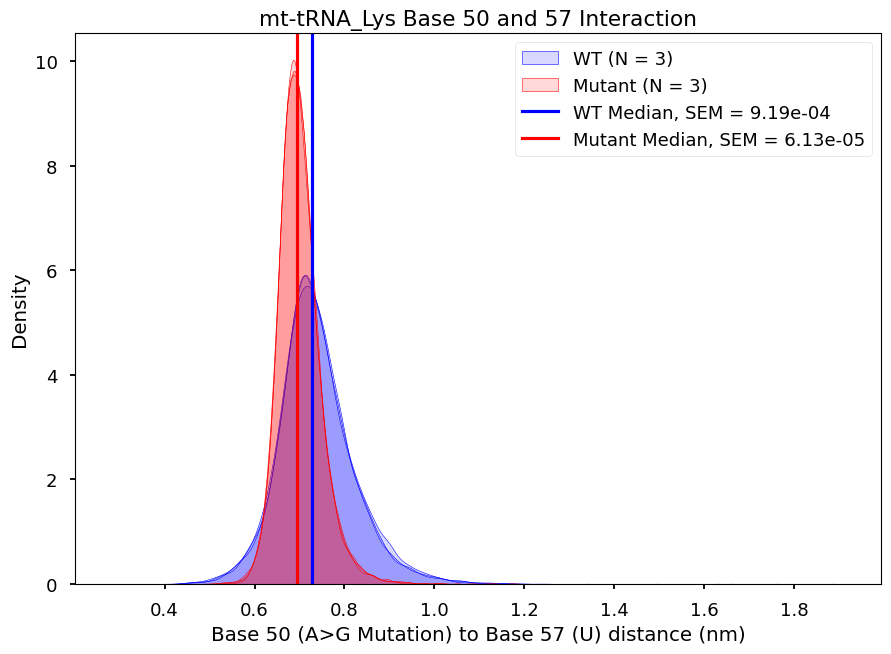

In [35]:
b1 = 49
b2 = 56
a = .15
color1, color2 = "blue", "red"
data1 = np.sqrt(np.sum(rvecslys[:,b1,b2]**2,axis=1))
data2 = np.sqrt(np.sum(rvecslys2[:,b1,b2]**2,axis=1))
data3 = np.sqrt(np.sum(rvecslys3[:,b1,b2]**2,axis=1))
data1 = data1[data1>.01]
data2 = data2[data2>.01]
data3 = data3[data3>.01]
sns.kdeplot(data1, color = color1, alpha = a, fill=True, label = "WT (N = 3)")
sns.kdeplot(data2, color = color1, alpha = a, fill=True)
sns.kdeplot(data3, color = color1, alpha = a, fill=True)
avg_med1 = np.mean((np.median(data1), np.median(data2), np.median(data3)))
SEM_med1 = np.std((np.median(data1), np.median(data2), np.median(data3))) / np.sqrt(3)

data4 = np.sqrt(np.sum(rvecslysM[:,b1,b2]**2,axis=1))
data5 = np.sqrt(np.sum(rvecslysM2[:,b1,b2]**2,axis=1))
data6 = np.sqrt(np.sum(rvecslysM3[:,b1,b2]**2,axis=1))
data4 = data4[data4>.01]
data5 = data5[data5>.01]
data6 = data6[data6>.01]
sns.kdeplot(data4, color = color2, alpha = a, fill=True, label = "Mutant (N = 3)")
sns.kdeplot(data5, color = color2, alpha = a, fill=True)
sns.kdeplot(data6, color = color2, alpha = a, fill=True)
avg_med2 = np.mean((np.median(data4), np.median(data5), np.median(data6)))
SEM_med2 = np.std((np.median(data4), np.median(data5), np.median(data6))) / np.sqrt(3)

plt.axvline(avg_med1, c = color1,
            label = f"WT Median, SEM = {np.format_float_scientific(SEM_med1, exp_digits=2, precision=2)}")
plt.axvline(avg_med2, c = color2, label = f"Mutant Median, SEM = {np.format_float_scientific(SEM_med2, exp_digits=2, precision=2)}")

plt.legend()
plt.xlabel(f"Base {b1+1} (A>G Mutation) to Base {b2+1} ({resleu[b2][:-5]}) distance (nm)")
plt.title(f"mt-tRNA_Lys Base {b1+1} and {b2+1} Interaction")

t_stat, p_val = stats.ttest_ind(data1, data4[data4>.01])
print(f"p_val is {p_val}")

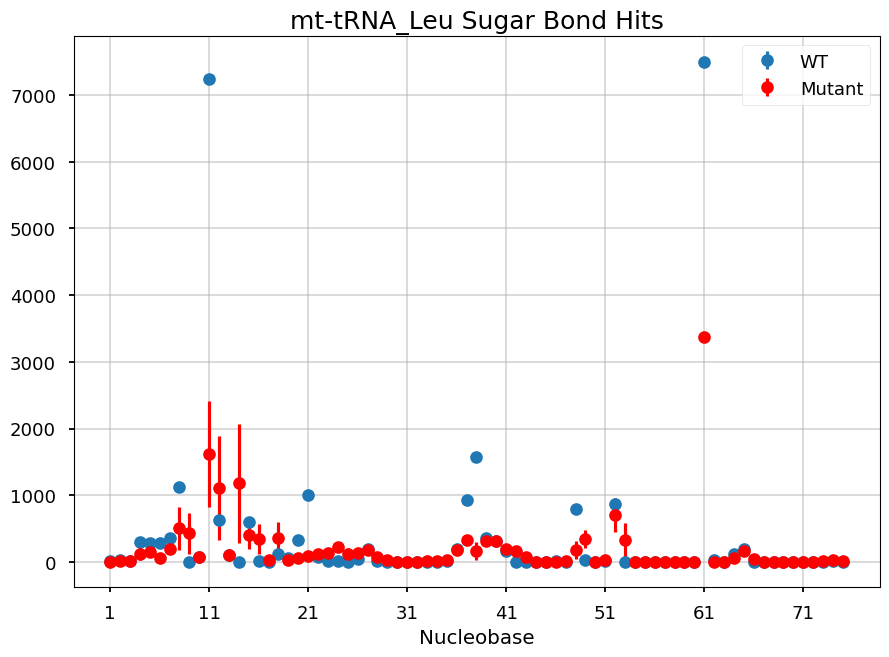

In [465]:
plt.errorbar(np.arange(len(leusugarm)), leusugarm, yerr=leusugarstd, fmt = 'o', label="WT")
plt.errorbar(np.arange(len(leuMsugarm)), leuMsugarm, yerr=leuMsugarstd, fmt = 'o', label="Mutant", color='red')
# plt.errorbar(13, means[13], yerr=sterr[13], color='red', label="Mutant Site", fmt='o')
plt.title("mt-tRNA_Leu Sugar Bond Hits", fontsize=18)
plt.xticks(np.arange(80, step = 10), np.arange(1, 1+len(leusugarm), step=10))
plt.xlabel("Nucleobase")
plt.grid(alpha=.5)
plt.legend()

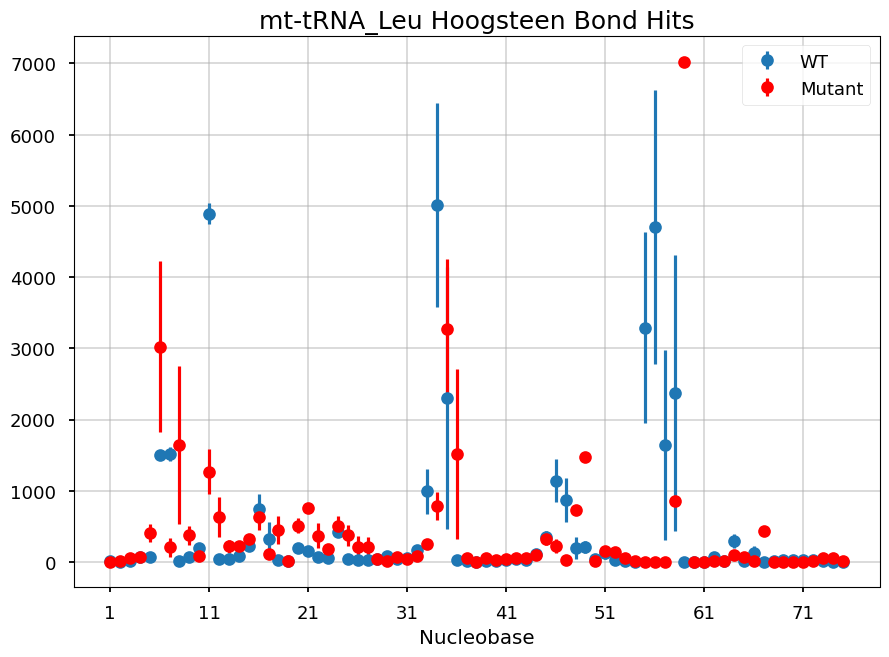

In [464]:
m = leuhoogm
Mm = leuMhoogm
mstd = leuhoogstd
Mstd = leuMhoogstd

plt.errorbar(np.arange(len(m)), m, yerr=mstd, fmt = 'o', label="WT")
plt.errorbar(np.arange(len(Mm)), Mm, yerr=Mstd, fmt = 'o', label="Mutant", color='red')
# plt.errorbar(13, means[13], yerr=sterr[13], color='red', label="Mutant Site", fmt='o')
plt.title("mt-tRNA_Leu Hoogsteen Bond Hits", fontsize=18)
plt.xticks(np.arange(80, step = 10), np.arange(1, 1+len(m), step=10))
plt.xlabel("Nucleobase")
plt.grid(alpha=.5)
plt.legend()

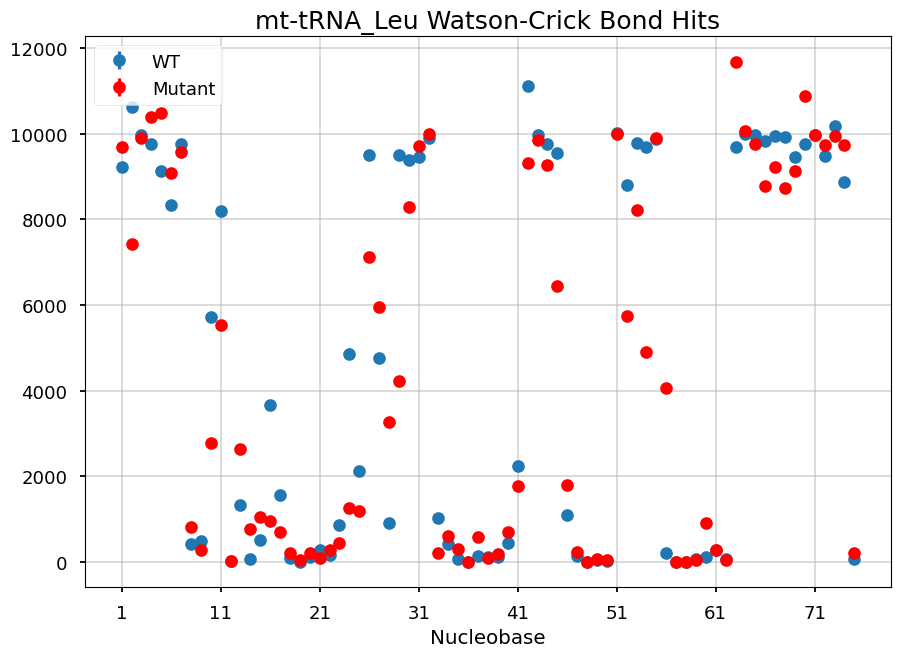

In [463]:
m = leuWCm
Mm = leuMWCm
mstd = leuWCstd
Mstd = leuMWCstd

plt.errorbar(np.arange(len(m)), m, yerr=mstd, fmt = 'o', label="WT")
plt.errorbar(np.arange(len(Mm)), Mm, yerr=Mstd, fmt = 'o', label="Mutant", color='red')
# plt.errorbar(13, means[13], yerr=sterr[13], color='red', label="Mutant Site", fmt='o')
plt.title("mt-tRNA_Leu Watson-Crick Bond Hits", fontsize=18)
plt.xticks(np.arange(80, step = 10), np.arange(1, 1+len(m), step=10))
plt.xlabel("Nucleobase")
plt.grid(alpha=.5)
plt.legend()

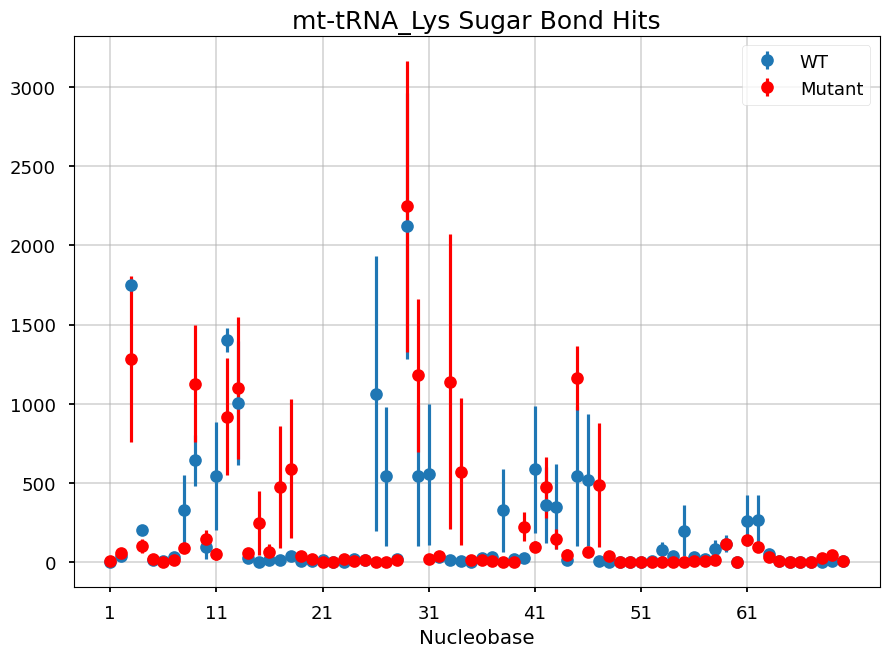

In [466]:
m = lyssugarm
Mm = lysMsugarm
mstd = lyssugarstd
Mstd = lysMsugarstd

plt.errorbar(np.arange(len(m)), m, yerr=mstd, fmt = 'o', label="WT")
plt.errorbar(np.arange(len(Mm)), Mm, yerr=Mstd, fmt = 'o', label="Mutant", color='red')
# plt.errorbar(13, means[13], yerr=sterr[13], color='red', label="Mutant Site", fmt='o')
plt.title("mt-tRNA_Lys Sugar Bond Hits", fontsize=18)
plt.xticks(np.arange(69, step = 10), np.arange(1, 1+len(m), step=10))
plt.xlabel("Nucleobase")
plt.grid(alpha=.5)
plt.legend()

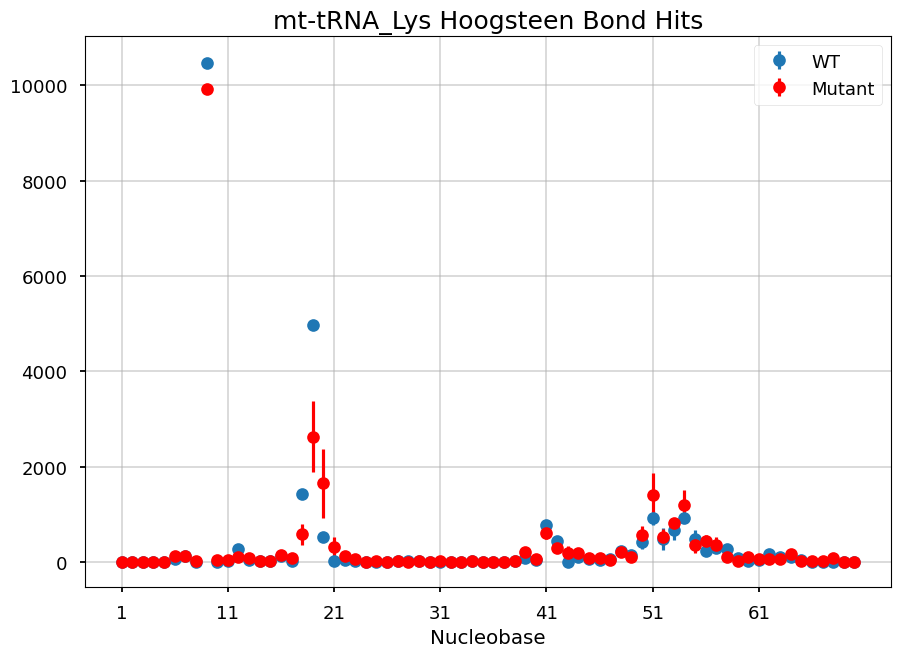

In [467]:
m = lyshoogm
Mm = lysMhoogm
mstd = lyshoogstd
Mstd = lysMhoogstd

plt.errorbar(np.arange(len(m)), m, yerr=mstd, fmt = 'o', label="WT")
plt.errorbar(np.arange(len(Mm)), Mm, yerr=Mstd, fmt = 'o', label="Mutant", color='red')
# plt.errorbar(13, means[13], yerr=sterr[13], color='red', label="Mutant Site", fmt='o')
plt.title("mt-tRNA_Lys Hoogsteen Bond Hits", fontsize=18)
plt.xticks(np.arange(69, step = 10), np.arange(1, 1+len(m), step=10))
plt.xlabel("Nucleobase")
plt.grid(alpha=.5)
plt.legend()

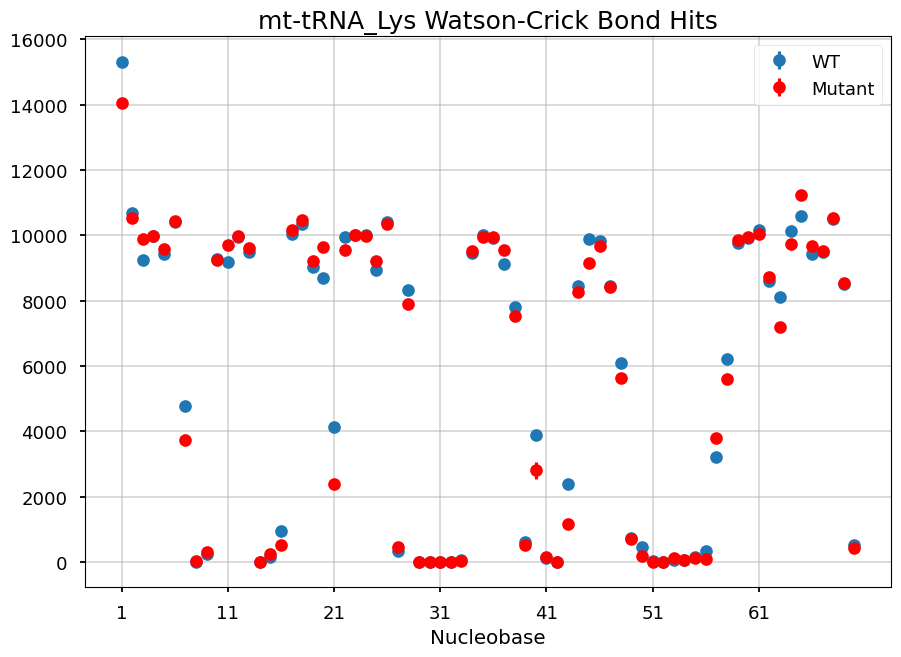

In [468]:
m = lysWCm
Mm = lysMWCm
mstd = lysWCstd
Mstd = lysMWCstd

plt.errorbar(np.arange(len(m)), m, yerr=mstd, fmt = 'o', label="WT")
plt.errorbar(np.arange(len(Mm)), Mm, yerr=Mstd, fmt = 'o', label="Mutant", color='red')
# plt.errorbar(13, means[13], yerr=sterr[13], color='red', label="Mutant Site", fmt='o')
plt.title("mt-tRNA_Lys Watson-Crick Bond Hits", fontsize=18)
plt.xticks(np.arange(69, step = 10), np.arange(1, 1+len(m), step=10))
plt.xlabel("Nucleobase")
plt.grid(alpha=.5)
plt.legend()

In [ ]:
%cd ..

In [149]:
# ermsds for structural comparison
e_leus = bb.ermsd("leu/leu.28963.pdb", "leuM/leuM.28964.pdb")
e_lys = bb.ermsd("lys/lys.28958.pdb", "lysM/lysM.28957.pdb")
e_met_lys = bb.ermsd("met/met.28956.pdb", "lys/lys.28958.pdb")
e_met_lysM = bb.ermsd("met/met.28956.pdb", "lysM/lysM.28957.pdb")
e_met_leu = bb.ermsd("met/met.28956.pdb", "leu/leu.28963_metmatch.pdb")
e_met_leuM = bb.ermsd("met/met.28956.pdb", "leuM/leuM.28964_metmatch.pdb")
e_val_lys = bb.ermsd("val/val.28955.pdb", "lys/lys.28958_valmatch.pdb")
e_val_lysM = bb.ermsd("val/val.28955.pdb", "lysM/lysM.28957_valmatch.pdb")
e_val_leu = bb.ermsd("val/val.28955.pdb", "leu/leu.28963_valmatch.pdb")
e_val_leuM = bb.ermsd("val/val.28955.pdb", "leuM/leuM.28964_valmatch.pdb")

e_list = [e_leus, e_lys, e_met_lys, e_met_lysM, e_met_leu, e_met_leuM, e_val_lys, e_val_lysM, e_val_leu, e_val_leuM]



# Loaded reference leu/leu.28963.pdb 
# Loaded target leuM/leuM.28964.pdb 
# Loaded reference lys/lys.28958.pdb 
# Loaded target lysM/lysM.28957.pdb 
# Loaded reference met/met.28956.pdb 
# Loaded target lys/lys.28958.pdb 
# Loaded reference met/met.28956.pdb 
# Loaded target lysM/lysM.28957.pdb 
# Loaded reference met/met.28956.pdb 
# Loaded target leu/leu.28963_metmatch.pdb 
# Loaded reference met/met.28956.pdb 
# Loaded target leuM/leuM.28964_metmatch.pdb 
# Loaded reference val/val.28955.pdb 
# Loaded target lys/lys.28958_valmatch.pdb 
# Loaded reference val/val.28955.pdb 
# Loaded target lysM/lysM.28957_valmatch.pdb 
# Loaded reference val/val.28955.pdb 
# Loaded target leu/leu.28963_valmatch.pdb 
# Loaded reference val/val.28955.pdb 
# Loaded target leuM/leuM.28964_valmatch.pdb 


In [496]:
# rmsds for structural comparison
r_leus = bb.rmsd("leu/leu.28963.pdb", "leuM/leuM.28964.pdb")
r_lys = bb.rmsd("lys/lys.28958.pdb", "lysM/lysM.28957.pdb")
r_met_lys = bb.rmsd("met/met.28956.pdb", "lys/lys.28958.pdb")
r_met_lysM = bb.rmsd("met/met.28956.pdb", "lysM/lysM.28957.pdb")
r_met_leu = bb.rmsd("met/met.28956.pdb", "leu/leu.28963_metmatch.pdb")
r_met_leuM = bb.rmsd("met/met.28956.pdb", "leuM/leuM.28964_metmatch.pdb")
r_val_lys = bb.rmsd("val/val.28955.pdb", "lys/lys.28958_valmatch.pdb")
r_val_lysM = bb.rmsd("val/val.28955.pdb", "lysM/lysM.28957_valmatch.pdb")
r_val_leu = bb.rmsd("val/val.28955.pdb", "leu/leu.28963_valmatch.pdb")
r_val_leuM = bb.rmsd("val/val.28955.pdb", "leuM/leuM.28964_valmatch.pdb")

r_list = [r_leus, 
          r_lys, 
          r_met_lys, 
          r_met_lysM, 
          r_met_leu, 
          r_met_leuM, 
          r_val_lys, 
          r_val_lysM, 
          r_val_leu, 
          r_val_leuM]


# found  897 atoms in common
# found  837 atoms in common
# found  837 atoms in common
# found  837 atoms in common
# found  837 atoms in common
# found  837 atoms in common
# found  825 atoms in common
# found  825 atoms in common
# found  825 atoms in common
# found  825 atoms in common


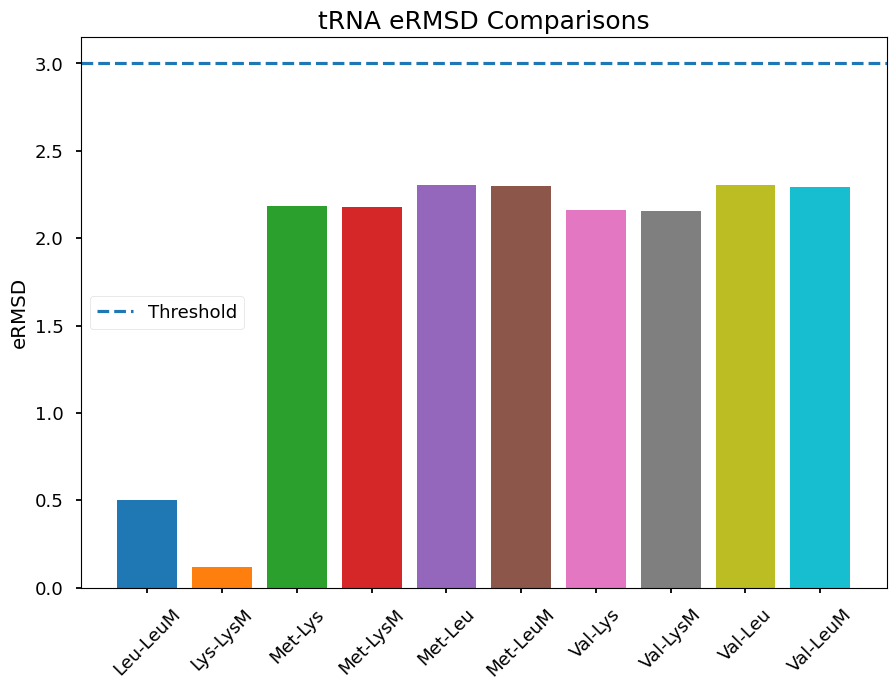

In [150]:
labellist = ["Leu-LeuM", 
            "Lys-LysM",
            "Met-Lys",
            "Met-LysM",
            "Met-Leu",
            "Met-LeuM",
            "Val-Lys",
            "Val-LysM",
            "Val-Leu",
            "Val-LeuM"]

for i in range(len(labellist)):
#     plt.plot(e_list[i], r_list[i], "X", label=labellist[i], alpha=.4, markersize=15)
    plt.bar(labellist[i], e_list[i])
# plt.grid(alpha=.5)
plt.ylabel("eRMSD")
# plt.xlabel("eRMSD")
# plt.xscale("log")
# plt.yscale("log")
plt.title("tRNA eRMSD Comparisons", fontsize=18)
# plt.xticks([0, .6, 2, 2.5], ['0', '.6', '2', '2.5'])
# plt.xticklabels()
# plt.axvline(3, '--', )
plt.xticks(rotation=45)
plt.axhline(3, linestyle='--', label="Threshold")
plt.legend()